# Analyse Exploratoire du jeu de Données `OpenFoodFacts`
*Les liens ne fonctionnent pas lorsque le notebook est affiché sur **Github**. Donc vous souhaitez visualiser ce notebook en ligne avec les liens menu actifs, vous pouvez le faire à cette adresse: https://nbviewer.org/github/Valkea/OC_AI_03/blob/main/Voila.ipynb )*

* [1. Objectif du projet](#P01)
* [2. Présentation générale du jeu de données](#P02)
* [3. Préselection des colonnes utiles](#P03)
* [4. Nettoyage du jeu de données](#P04)
    * [Suppression des doublons](#clean_duplicates)
    * [Suppression des valeurs aberrantes](#clean_outliers)
    * [Corrélations linéaires](#clean_correlations)
    * [Imputations des valeurs manquantes](#clean_imputations)
    * [Suppression des lignes aux valeurs nutritionnelles illogiques](#clean_logic)
* [5. Démarche méthodologique d’analyse de données](#P05)
    * [Analyses univariées](#analysis_univariate)
    * [Analyses multivariées](#analysis_multivariate)
    * [Analyse en composantes principales](#pca)
    * [Test statistique](#anova)
* [6. Conclusions](#conclusion)

In [1]:
#%matplotlib widget

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# 1. Objectif  <a class="anchor" id="P01"></a>

Le Nutri-grade est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce grade à partir des indications disponibles sur les étiquettes des produits (ou même simplement en scannant le code-barre).

**Nous allons donc essayer de calculer le nutri-grade en nous basant sur les données disponibles sur l'étiquette d'un produit.**

En cherchant sur le site https://www.santepubliquefrance.fr on peut trouver des [informations](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

#### Précisions utiles

- Pour calculer la teneur de fruits et légumes, les féculents (tel que pomme de terre, patate douce, taro, manioc et tapioca) ne sont pas pris en compte.
- Pour les fromages, la teneur en protéines est toujours prise en compte car celle-ci est liée à celle en calcium. Ceci améliore le nutri-score des fromages et la cohérence entre celui-ci et les recommandations nutritionnelles du Haut Conseil de la Santé Publique. Celles-ci recommandent en effet de consommer des produits laitiers plusieurs fois par jour. 

# 2. Présentation générale du jeu de données <a class="anchor" id="P02"></a>

Le [jeu de données](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) utilisé dans le cadre de l'appel à projets de l'agence *Santé publique France* qui consiste à rendre les données de santé plus accessibles, est une liste de 2.251.894 produits alimentaires répertoriés par les volontaires de l'association [Open Food Facts](https://world.openfoodfacts.org).

Chacun des produits référencé est décrit par un certain nombre de caractèristiques nutritionels *(taux de graisse, de sucre, de sel, de fibres, de protéines, de vitamines, etc.)* et par des méta-données *(code-barre, nom du produit, catégorie, lieu de production, date d'ajout dans la DB, auteur de l'ajout, etc.)*.

> Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée,<br> donc **nous avons crée un jeu de données réduit (dans Cleaning_01.ipynb) que nous allons utiliser ici**.

In [3]:
# Commençons par charger les colonnes (et leur dtype) sélectionnées dans le premier notebook

filename = 'data/dtypes_low.csv'
dtypes_df = pd.read_csv(filename, sep=',', index_col=0)
cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

In [4]:
# Puis chargeons le jeu de données réduit

filename = 'data/en.openfoodfacts.org.products.csv'
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_keep, nrows=10000)

In [5]:
# Transformons les valeurs neutres par des `None` dans les colonnes numériques.

for cat in data.select_dtypes(exclude=np.number).columns:
    data[cat].replace(['unknown',np.NaN, "NaN"], None, inplace=True)

(Renommons la colonne `fruits-vegetables-nuts-estimate-from-ingredients_100g` en `FVN_estimate_100g`, pour faciliter la visualisation des tableaux & graphiques à venir)

In [6]:
data.rename(columns={'fruits-vegetables-nuts-estimate-from-ingredients_100g':'FVN_estimate_100g'}, inplace=True)

### Explorons le jeu de données

In [7]:
data.head(3)

,code,url,product_name,quantity,categories_tags,labels_tags,ingredients_tags,allergens,traces_tags,serving_size,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,FVN_estimate_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,jeunes pousses,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,L.casei,None,None,None,"en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...",None,None,None,...,9.8,NaN,2.7,0.1,0.04,NaN,NaN,NaN,NaN,0.0
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,Vitória crackers,None,None,None,None,None,None,None,...,15.0,NaN,7.8,1.4,0.56,NaN,NaN,NaN,NaN,NaN


In [8]:
print(f"Le jeu de données contient {data.shape[1]} colonnes et {data.shape[0]} lignes")

Le jeu de données contient 36 colonnes et 10000 lignes


In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Survolons les données numériques

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
serving_quantity,4672.000,85.111,525.022,0.000,28.000,40.000,99.000,35371.000
additives_n,5001.000,3.352,4.416,0.000,0.000,2.000,5.000,33.000
nutriscore_score,3741.000,11.390,9.390,-13.000,3.000,13.000,19.000,36.000
energy_100g,8362.000,1251.991,1077.201,0.000,456.000,1255.000,1795.000,53000.000
fat_100g,8288.000,14.646,17.846,0.000,0.700,7.140,23.333,222.000
saturated-fat_100g,7648.000,6.133,8.955,0.000,0.050,2.588,8.209,100.000
trans-fat_100g,3040.000,0.055,0.941,0.000,0.000,0.000,0.000,44.250
cholesterol_100g,3120.000,0.022,0.052,0.000,0.000,0.006,0.029,1.654
carbohydrates_100g,8314.000,32.600,32.908,0.000,6.780,25.913,54.297,1550.000
sugars_100g,8070.000,17.195,26.208,0.000,1.400,6.250,27.198,1400.000


> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> Il faudra s'occuper de ces valeurs aberrantes lors du nettoyage.

--- 

#### Survolons les données nominales

In [11]:
data.describe(exclude="number").T

,count,unique,top,freq
code,10000,10000,00000000000000225,1
url,10000,10000,http://world-en.openfoodfacts.org/product/0000...,1
product_name,9615,8520,Pure whey protein,19
quantity,1178,485,16 oz,72
categories_tags,4798,993,en:snacks,340
labels_tags,912,269,en:organic,193
ingredients_tags,4999,4148,"en:pasteurised-milk,en:dairy,en:milk,en:lactic...",22
allergens,1111,94,en:milk,306
traces_tags,212,93,en:nuts,22
serving_size,4684,1626,1 ONZ (28 g),269


> Sur la base des colonnes `code` et `url` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon.
>
> Il faudra s'occuper de ces doublons lors du nettoyage.

---

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [12]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes / présentes et leur taux

def print_fill_rate(dataset, col_array):
    fill_count = dataset[col_array].notnull().sum()
    fill_ratio = fill_count/dataset.shape[0]*100.0
    
    total = dataset.shape[0]
    max_size = max([len(x) for x in dataset.columns])
    col_size = 15
    
    print(f"{'COLONNE'.rjust(max_size)} | {'LIGNES VIDES'.center(col_size)} | {'REMPLISSAGE'.rjust(col_size)} \n{'-'*111}")
    
    for k, v in zip(fill_count.keys(), fill_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(max_size)} | {total-v:15} | {fraction:15.2f}%")
        
    return fill_ratio

In [13]:
fill_ratio = print_fill_rate(data, data.columns)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
              code |               0 |          100.00%
               url |               0 |          100.00%
      product_name |             385 |           96.15%
          quantity |            8822 |           11.78%
   categories_tags |            5202 |           47.98%
       labels_tags |            9088 |            9.12%
  ingredients_tags |            5001 |           49.99%
         allergens |            8889 |           11.11%
       traces_tags |            9788 |            2.12%
      serving_size |            5316 |           46.84%
  serving_quantity |            5328 |           46.72%
       additives_n |            4999 |           50.01%
    additives_tags |            6560 |           34.40%
  nutriscore_score |            6259 |           37.41%
  nutriscore_grade |            6259 |          

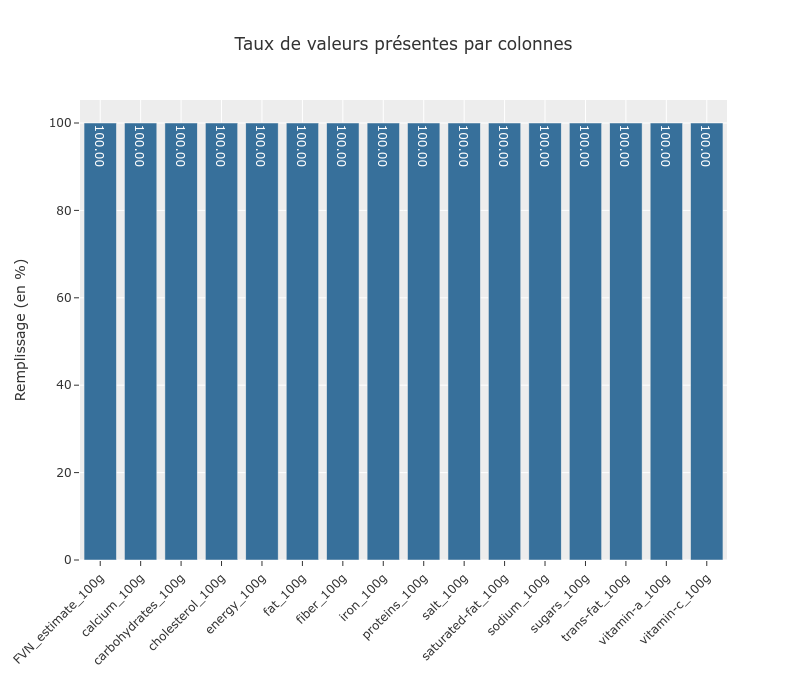

In [153]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=700,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
             text=[f"{x:.2f}" for x in fill_ratio_df.fill_rate],
            )

fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45)
fig.show()

# 3. Préselection des colonnes utiles <a class="anchor" id="P03"></a>

Malgré une première sélection, il reste encore beaucoup de colonnes dans ce jeu de données. Nous allons donc nous appuyer sur les les indications de la documentation du Nutri-grade pour réduire notre sélection aux colonnes les plus utiles pour une application consistant à prédire le Nutrigrade ([Voir les infos dans l'objectif du projet](#P01))

Pour rappel, voici les éléments utilisés dans le calcule du Nutri-score et donc du Nutri-grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

### `Informations nutritionelles`
> Prenons déjà tous les indicateurs nutritionnels `*_100g`

In [15]:
var_selected = {x for x in data.columns if x.endswith('_100g')}

### `Informations de catégorisation du produit`

> Afin de pouvoir explorer la relation entre le type de produit et les variables que nous avons gardé précédemment, nous allons garder une colonne de catégorisation.

> Il y a trois variables qui pourraient servir à catégoriser les produits; `main_category`, `pnns_groups_1` et `pnns_groups_2`.

#### Regardons les trois colonnes candidates plus en détails

In [16]:
from itertools import zip_longest

In [17]:
def eval_groups(maxiter=20):
    x = data.main_category.value_counts(dropna=False)
    y = data.pnns_groups_1.value_counts(dropna=False)
    z = data.pnns_groups_2.value_counts(dropna=False)

    size=25
    print(f"{'main_category'.upper().rjust(size+9)}\t{'pnns_groups_1'.upper().rjust(size+9)}\t{'pnns_groups_2'.upper().rjust(size+9)}\n{'-'*115}")
    for i,(ai,a, bi,b, ci,c) in enumerate(zip_longest(x.index,x, y.index, y,z.index, z)):
        a = 0 if a == None else a
        b = 0 if b == None else b
        c = 0 if c == None else c
        print(f"{str(ai)[:size].rjust(size)} :{a:7}\t{str(bi)[:size].rjust(size)} :{b:7}\t{str(ci)[:size].rjust(size)} :{c:7}")
        if i > maxiter:
            break
            
eval_groups(15)

                     MAIN_CATEGORY	                     PNNS_GROUPS_1	                     PNNS_GROUPS_2
-------------------------------------------------------------------------------------------------------------------
                     None :   5202	                     None :   6385	                     None :   6385
                en:snacks :    340	            Sugary snacks :   1419	                   Sweets :    774
     en:chocolate-candies :    308	  Milk and dairy products :    477	       Biscuits and cakes :    556
       en:confectioneries :    296	     Cereals and potatoes :    365	     Dressings and sauces :    247
                 en:cakes :    238	           Fat and sauces :    306	          Milk and yogurt :    225
         en:salted-snacks :    178	          Composite foods :    287	                   Cheese :    216
               en:cheeses :    155	                Beverages :    274	           One-dish meals :    197
       en:frozen-desserts :    143	         

#### Regardons le nombre de catégories dans chaque colonne

In [18]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].nunique()

main_category    846
pnns_groups_1     10
pnns_groups_2     38
dtype: int64

#### Affichons leurs taux de remplissage

In [19]:
data[['main_category', 'pnns_groups_1', 'pnns_groups_2']].notnull().mean(0)

main_category   0.480
pnns_groups_1   0.361
pnns_groups_2   0.361
dtype: float64

> Bien que `main_category` soit légèrement plus remplie que les deux autres (après le nettoyage des NaN fait plus haut...), le découpage qui apparait dans `pnns_groups_2` semble être le plus intéressant car moins granulaire; on va donc prendre cette colonne.

In [20]:
var_selected.add('pnns_groups_2')

### `Informations d'identification du produit`

> Pour aider à trouver les doublons, on va ajouter les variables `code` et `product_name`.

In [21]:
var_selected.add('code')
var_selected.add('product_name')

### `Scores de référence`
> Comme le propos est de travailler sur le nutri-grade, il convient d'ajouter les colonnes concernées...

In [22]:
var_selected.add('nutriscore_score')
var_selected.add('nutriscore_grade')
var_selected.add('nova_group')

### Colonnes séléctionnées pour une application de prédiction du Nutri-grade

In [23]:
var_selected = sorted(sorted(var_selected), key=lambda x: x.endswith('_100g'), reverse=False)
var_selected

['code',
 'nova_group',
 'nutriscore_grade',
 'nutriscore_score',
 'pnns_groups_2',
 'product_name',
 'FVN_estimate_100g',
 'calcium_100g',
 'carbohydrates_100g',
 'cholesterol_100g',
 'energy_100g',
 'fat_100g',
 'fiber_100g',
 'iron_100g',
 'proteins_100g',
 'salt_100g',
 'saturated-fat_100g',
 'sodium_100g',
 'sugars_100g',
 'trans-fat_100g',
 'vitamin-a_100g',
 'vitamin-c_100g']

In [24]:
data_nutri = data[[*var_selected]]

# 4. Nettoyage du jeu de données <a class="anchor" id="P04"></a>

In [25]:
def print_current_size(data, size=[]):
    num_lines = data.shape[0]
    diff = ""
    if size != [] :
        diff = f"({size[-1]-num_lines} lignes de moins)"
    size.append(num_lines)
    print(f"A ce stade le jeu de données contient {num_lines} lignes {diff}")

In [26]:
data_clean = data_nutri.copy()
print_current_size(data_clean)

A ce stade le jeu de données contient 10000 lignes 


## 4.1 Suppression des lignes où toutes les valeurs nutritionnelles sont vides <a class="anchor" id="clean_empties"></a>

In [27]:
selection = list(data_clean.select_dtypes(include=np.number).columns)
selection.remove('nutriscore_score')

In [28]:
data_clean = data_clean[data_clean[selection].notnull().apply(lambda x: any(x), axis=1)]
print_current_size(data_clean)

A ce stade le jeu de données contient 8760 lignes (1240 lignes de moins)


## 4.2 Suppression des doublons <a class="anchor" id="clean_duplicates"></a>

#### Supprimons les doublons en nous basant sur la colonne `code`

In [29]:
data_clean.drop_duplicates(subset=['code'], keep='first', inplace=True)
print_current_size(data_clean)

A ce stade le jeu de données contient 8760 lignes (0 lignes de moins)


#### Supprimons les lignes similaires **en excluant** le `code` *(donc des produits au nom et valeurs nutritives similaires)*

In [30]:
cols_without_code = list(data_clean.columns)
cols_without_code.remove("code")

In [31]:
data_clean.drop_duplicates(subset=cols_without_code, keep='first', inplace=True)
print_current_size(data_clean)

A ce stade le jeu de données contient 8580 lignes (180 lignes de moins)


## 4.2 Suppressions des valeurs aberrantes <a class="anchor" id="clean_outliers"></a>

Les valeurs nutritionnelles `*_100g` ne peuvent logiquement pas dépasser les 100g, ni avoir moins de 0g.

Deux options se présentent à nous:
1. Supprimer les lignes qui présentent des valeurs aberrantes en partant du principe que si une donnée de la ligne est fausse, les autres sont incertaines.
2. Remplacer les valeurs aberrantes par des None et les imputer ensuite.

> Nous allons donc procèder en deux temps... d'abord supprimer les lignes qui sont en dehors de l'intervalle logique [0,100], puis ensuite remplacer les valeurs aberrantes en regard des valeurs maximum connues pour un nutriment donnée.

In [32]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g') and x != 'energy_100g']

#### Regardons à nouveau les valeurs des colonnes numériques avant de supprimer les valeurs aberrantes

In [33]:
data_clean[var_nutri].describe().T

,count,mean,std,min,25%,50%,75%,max
FVN_estimate_100g,4843.000,6.105,18.903,0.000,0.000,0.000,0.000,125.800
calcium_100g,3092.000,0.354,13.146,0.000,0.016,0.071,0.143,731.000
carbohydrates_100g,8150.000,32.636,32.937,0.000,7.013,26.000,54.512,1550.000
cholesterol_100g,3030.000,0.022,0.052,0.000,0.000,0.006,0.029,1.654
fat_100g,8124.000,14.665,17.828,0.000,0.800,7.265,23.333,222.000
fiber_100g,4789.000,3.239,15.333,0.000,0.000,1.600,3.571,1000.000
iron_100g,3138.000,0.009,0.432,0.000,0.000,0.001,0.002,24.200
proteins_100g,8157.000,9.177,13.233,0.000,1.900,5.560,11.000,300.000
salt_100g,7534.000,2.604,35.676,0.000,0.132,0.600,1.282,1880.000
saturated-fat_100g,7530.000,6.086,8.904,0.000,0.041,2.595,8.050,100.000


#### 1. Supprimons les lignes dont les valeurs nutritionnelles sont hors intervalle [0,100] 
Sauf `energy_100g` qui est en kj.

In [34]:
# Définissons une fonction permettant de supprimer les lignes qui présentent des valeurs hors intervalle

def drop_row_values(dt, col_name, min_v=None, max_v=None):
    count_start = dt.shape[0]
    
    dt = dt[((dt[col_name].notnull()) & (dt[col_name] >= min_v) & (dt[col_name] <= max_v)) | (dt[col_name].isnull())]
        
    count_end = dt[col_name].shape[0]
    print(f"On a supprimé {count_start-count_end:6} lignes sur {col_name}")
        
    return dt

In [35]:
for col in var_nutri:
    data_clean = drop_row_values(data_clean, col, min_v=0, max_v=100)

On a supprimé      3 lignes sur FVN_estimate_100g
On a supprimé      1 lignes sur calcium_100g
On a supprimé      4 lignes sur carbohydrates_100g
On a supprimé      0 lignes sur cholesterol_100g
On a supprimé      1 lignes sur fat_100g
On a supprimé      1 lignes sur fiber_100g
On a supprimé      0 lignes sur iron_100g
On a supprimé      0 lignes sur proteins_100g
On a supprimé     14 lignes sur salt_100g
On a supprimé      0 lignes sur saturated-fat_100g
On a supprimé      0 lignes sur sodium_100g
On a supprimé      0 lignes sur sugars_100g
On a supprimé      0 lignes sur trans-fat_100g
On a supprimé      0 lignes sur vitamin-a_100g
On a supprimé      0 lignes sur vitamin-c_100g


In [36]:
print_current_size(data_clean)

A ce stade le jeu de données contient 8556 lignes (24 lignes de moins)


#### 2. Remplaçons les valeurs nutritionnelles hors intervalle métier par des None (pour pouvoir ensuite les imputer)

En cherchant sur Internet on peut trouver les valeurs réelles maximales constatées pour plusieurs de ces colonnes, nous allons nous en servir pour

> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// **Cervelle de veau cuite**

> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// **Huile d'avocat**

> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// **Pain de friture**

> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// **Gélatine alimentaire**

> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `salt_100g` le maximum semble être à **100g** pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// **Boudin noir**

> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// **Meloukhia en poudre**

> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// **Cannelle**

> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// **Huile d'avocat**

> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// **Huile d'avocat**

> Pour `vitamin-a_100g` le maximum semble être à **0.03g** (30 000 μg) pour 100g /// **Huile de de foie de morrue**

> Pour `vitamin-c_100g` le maximum semble être à **0.2g** (200 mg) pour 100g /// **Cassis**

In [37]:
max_values = {
    'cholesterol_100g':3.1,
    'fat_100g':100,
    'saturated-fat_100g':92.6,
    'proteins_100g':87.6,
    'sugars_100g':99.8,
    'carbohydrates_100g':99.8,
    'sodium_100g':39.1,
    'salt_100g':100,
    'iron_100g':0.0064,
    'calcium_100g':2,
    'fiber_100g':43.5,
    'energy_100g':3756.6,
    'vitamin-a_100g':0.03,
    'vitamin-c_100g':0.2,
}

In [38]:
# Définissons une fonction permettant d'appliquer un filtre sur les valeurs hors bornes

def clip_column_values(dt, col_name, min_v=None, max_v=None, min_new=None, max_new=None):
    count_start = dt[col_name].isin([max_new,min_new]).sum()
    
    if(min_v != None):
        dt[col_name].mask(dt[col_name] < min_v, min_new, inplace=True)
    if(max_v != None):
        dt[col_name].mask(dt[col_name] > max_v, max_new, inplace=True)
        
    count_end = dt[col_name].isin([max_new,min_new]).sum()
    
    print(f"On a modifié {count_end-count_start:6} lignes sur {col_name}")
        
    return dt

In [39]:
for col in max_values:
    data_clean = clip_column_values(data_clean, col, max_v=max_values[col], max_new=None)

On a modifié      0 lignes sur cholesterol_100g
On a modifié      0 lignes sur fat_100g
On a modifié      0 lignes sur saturated-fat_100g
On a modifié      0 lignes sur proteins_100g
On a modifié      0 lignes sur sugars_100g
On a modifié      0 lignes sur carbohydrates_100g
On a modifié      0 lignes sur sodium_100g
On a modifié      0 lignes sur salt_100g
On a modifié      0 lignes sur iron_100g
On a modifié      0 lignes sur calcium_100g
On a modifié      0 lignes sur fiber_100g
On a modifié      0 lignes sur energy_100g
On a modifié      0 lignes sur vitamin-a_100g
On a modifié      0 lignes sur vitamin-c_100g


In [40]:
print_current_size(data_clean)

A ce stade le jeu de données contient 8556 lignes (0 lignes de moins)


#### Regardons à nouveau les valeurs numériques après la suppression de ces valeurs aberrantes.

In [41]:
data_clean[[*var_nutri, 'energy_100g']].describe().T

,count,mean,std,min,25%,50%,75%,max
FVN_estimate_100g,4835.000,6.037,18.717,0.000,0.000,0.000,0.000,100.000
calcium_100g,3088.000,0.116,0.169,0.000,0.016,0.071,0.143,1.667
carbohydrates_100g,8088.000,32.013,26.916,0.000,7.000,25.605,54.000,99.300
cholesterol_100g,3029.000,0.022,0.052,0.000,0.000,0.006,0.029,1.654
fat_100g,8102.000,14.601,17.590,0.000,0.800,7.200,23.330,100.000
fiber_100g,4756.000,2.869,4.243,0.000,0.000,1.600,3.570,40.000
iron_100g,3030.000,0.001,0.001,0.000,0.000,0.001,0.002,0.006
proteins_100g,8125.000,9.038,12.518,0.000,1.820,5.560,11.000,87.000
salt_100g,7517.000,1.516,6.005,0.000,0.130,0.600,1.279,99.906
saturated-fat_100g,7510.000,6.067,8.835,0.000,0.020,2.586,8.040,86.670


## 4.3 Corrélations linéaires <a class="anchor" id="clean_correlations"></a>
On va étudier les corrélations linéaires des variables quantitatives pour voir ce qui peut être fait au niveau des imputations et avoir une idée des rélations entre variables avant ces imputations.

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.

Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

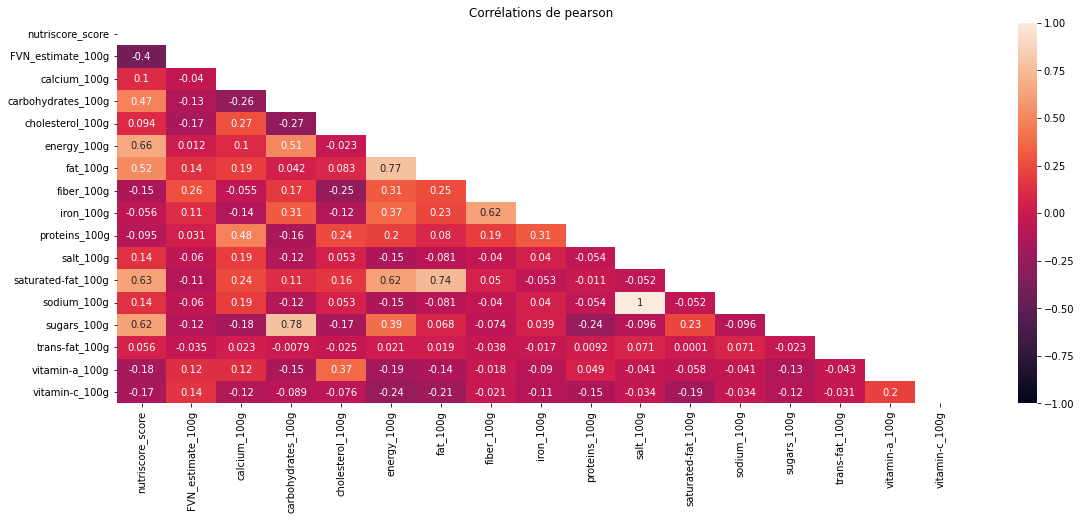

<function __main__.show_correlation1(cor_name)>

In [42]:
data_corr_1 = data_clean.sample(frac=0.1).copy()

def show_correlation1(cor_name):
    
    fig = plt.figure(figsize=(19,7))
    corr= data_corr_1.corr(method=cor_name)
    matrix = np.triu(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
    ax.set_title(f'Corrélations de {cor_name}')
    #ax.legend()
    
    plt.show() 
    
interact(show_correlation1, cor_name=["pearson", "spearman"])

> Si on s'intéresse à la colonne **`nutriscore_score`**, on remarque qu'elle est **corrélée à divers degrès avec la plupart des colonnes** considerées comme favorables ou défavorables dans la documentation:
> 
> #### Éléments défavorables au score:
> 
> - `energy_100g` = 0.58 / 0.60 << **Apport calorique pour cent grammes**.
> - `sugars_100g` = 0.43 / 0.33 << **Teneur en sucre**.
> - `saturated-fat_100g` = 0.58 / 0.64 << **Teneur en graisses saturées**.
> - `salt_100g` = 0.15 / 0.34 << **Teneur en sel**.
>
> #### Éléments favorables au score:
>
> - `FVN_estimate_100g` = -0.24 / -0.19 << **Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive**.
> - `fiber_100g` = -0.17 / -0.2 << **Teneur en fibres**.
> - `proteins_100g` = 0.08 / 0.085 << **Teneur en protéines**.
>
> Le sens des corrélations constatées est d'ailleurs raccord avec ce que l'on était en droit d'espèrer d'après la documentation du Nutriscore *(plus le `nutriscore_score` est grand moins c'est favorable et inversement plus il est bas et plus c'est favorable)*; une corrélation positive (avec un mauvais score) pour `energy_100g`, `sugars_100g`, `saturated-fat_100g`, `salt_100g` et une corrélation négative (avec un mauvais score) pour `fiber_100g`, `FNV_estimate_100g`. Seule la colonne `proteins_100g` ne semble pas répondre aux attentes, mais la laison avec le score ne semble de toutes façons pas très forte.
>
> #### Par ailleurs, on note également des corrélations moyennes avec des éléments non pris en compte par la documentation:
>
> - `fat_100g` = 0.47 / 0.59
> - `cholesterol_100g` = 0.19 / 0.26
> - `carbohydrates_100g` = 0.24 / 0.18
> - `calcium_100g` = 0.14 / 0.036
> - `sodium_100g` = 0.16 / 0.34
> - `vitamin-c_100g` = -0.13 / -0.27

> Si l'on regade les autres colonnes, on voit que certaines d'entre elles n'ont qu'une seule ou même **aucune corrélation linéaire** *(Pearson)* avec les autres et très peu de corrélation monotones *(Spearman)*.
> - C'est le cas de `trans-fat_100g`, `vitamin-a_100g` ou `vitamin-c_100g` qui de fait ne devrait pas être très utiles ni pour prédire le `nutriscore-score` ni pour imputer les autres colonnes.
>
> En revanche, certaines colonnes présentent des corrélations moyennes ou fortes intéressantes:
> - La corrélation est maximale entre `salt_100g` et `sodium_100g` *(ce qui n'est en soit pas étonnant car pour effectuer une conversion entre sodium et sel, il faut multiplier la quantité de sodium par 2,54)*.
> - La corrélation est haute entre `energy_100g` et `fat_100g`.
> - La corrélation est moyenne entre `energy_100g` et `carbohydrates_100g`, `proteins_100g`, `calcium_100g`, `saturated-fat_100g` ou `fiber_100g`.
> - La corrélation est moyenne ou basse entre plusieurs types de graisses `fat_100g`, `saturated-fat_100g`, `cholesterol_100g`.

---

#### Vérifions les relations entre `nutriscore_score` et les autres variables numériques <a class="anchor" id="clean_linear"></a>
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [43]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample = data_clean.sample(frac=0.1, random_state=0)
data_sample.dropna(inplace=True)

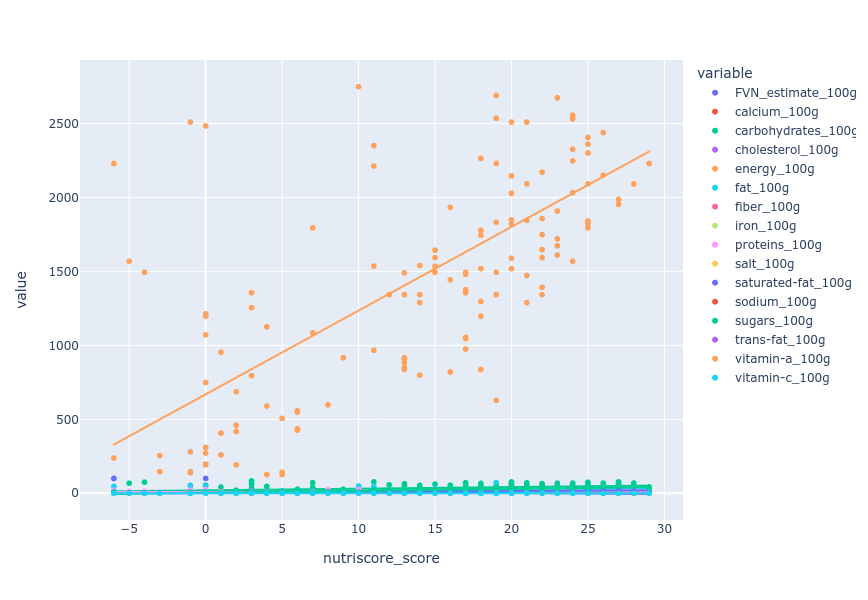

In [44]:
fig = px.scatter(data_sample, x="nutriscore_score", y=var_nutri, trendline="ols", height=600, width=1000)    
fig.show()
results = px.get_trendline_results(fig)

*(Utilisez le selecteur pour changer de variable)*

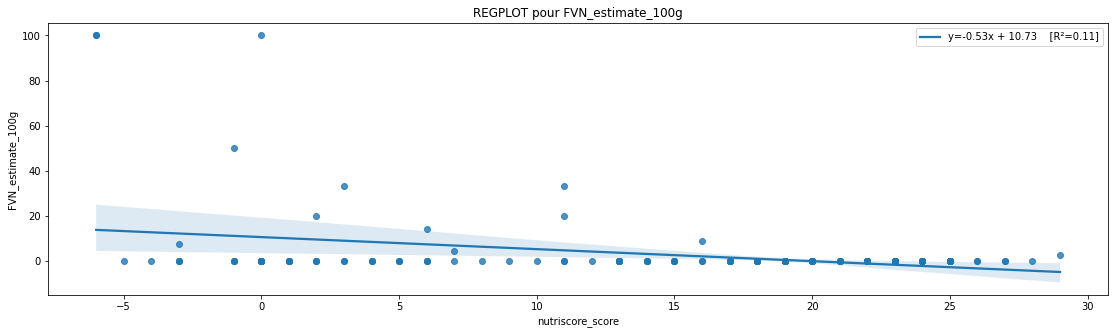

<function __main__.select_regplot(col)>

In [45]:
from scipy import stats

data_regplot1 = data_sample.copy()

def select_regplot(col):
    fig = plt.figure(figsize=(19,5))

    slope, intercept, r_value, pv, se = stats.linregress(data_regplot1['nutriscore_score'], data_regplot1[col])
    sns.regplot(x="nutriscore_score", y=col, data=data_regplot1, line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"REGPLOT pour {col}")
    plt.legend()

    plt.show()

interact(select_regplot, col=var_nutri)

> En regardant les coéfficients de déterminations R², on constate exactement les même tendances qu'avec les coefficients de Pearson et Spearman. On a une corrélation moyennement forte pour `saturated-fat_100g`, `energy_100g` et `sugars_100g`, une corrélation faible pour `salt_100g`, `FVN_estimate_100g` et `fiber_100g`, aucune corrélation pour `proteins_100g`.
>
> - `energy_100g`:        **R² = 0.44** *[Pearson = 0.58 & Spearman = 0.60]*
> - `saturated-fat_100g`: **R² = 0.43** *[Pearson = 0.58 & Spearman = 0.64]*
> - `sugars_100g`:        **R² = 0.28** *[Pearson = 0.43 & Spearman = 0.33]*
> - `FVN_estimate_100g`:  **R² = 0.08** *[Pearson = -0.24 & Spearman = -0.19]*
> - `salt_100g`:          **R² = 0.07** *[Pearson = 0.15 & Spearman = 0.34]*
> - `fiber_100g`:         **R² = 0.04** *[Pearson = -0.17 & Spearman = -0.20]*
> - `proteins_100g`:      **R² = 0.01** *[Pearson = 0.08 & Spearman = 0.085]*

> Cette tendance se vérifie avec la plupart des autres colonnes que nous avions remarquées plus haut:
> - `fat_100g`:           **R² = 0.36** *[Pearson = 0.47 & Spearman = 0.59]*
> - `carbohydrates_100g`  **R² = 0.10** *[Pearson = 0.24 & Spearman = 0.18]*
> - `cholesterol_100g`    **R² = 0.08** *[Pearson = 0.19 & Spearman = 0.26]*
> - `sodium_100g`         **R² = 0.07** *[Pearson = 0.16 & Spearman = 0.34]*
> - `calcium_100g`        **R² = 0.03** *[Pearson = 0.14 & Spearman = 0.036]*
> - `vitamin-c_100g`      **R² = 0.02** *[Pearson = -0.13 & Spearman = -0.27]*

## 4.4 Imputations des valeurs manquantes <a class="anchor" id="clean_imputations"></a>

In [46]:
data_tmp = data_clean.copy()

#### Commençons par regarder quelles sont les valeurs manquantes

In [47]:
var_nutri = [x for x in data_tmp.columns if x.endswith('_100g')]

In [48]:
fill_ratio = print_fill_rate(data_tmp, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
 FVN_estimate_100g |            3721 |           56.51%
      calcium_100g |            5468 |           36.09%
carbohydrates_100g |             468 |           94.53%
  cholesterol_100g |            5527 |           35.40%
       energy_100g |             424 |           95.04%
          fat_100g |             454 |           94.69%
        fiber_100g |            3800 |           55.59%
         iron_100g |            5526 |           35.41%
     proteins_100g |             431 |           94.96%
         salt_100g |            1039 |           87.86%
saturated-fat_100g |            1046 |           87.77%
       sodium_100g |            1043 |           87.81%
       sugars_100g |             672 |           92.15%
    trans-fat_100g |            5605 |           34.49%
    vitamin-a_100g |            5974 |          

#### Affichons ces taux sous forme de graphique interactif

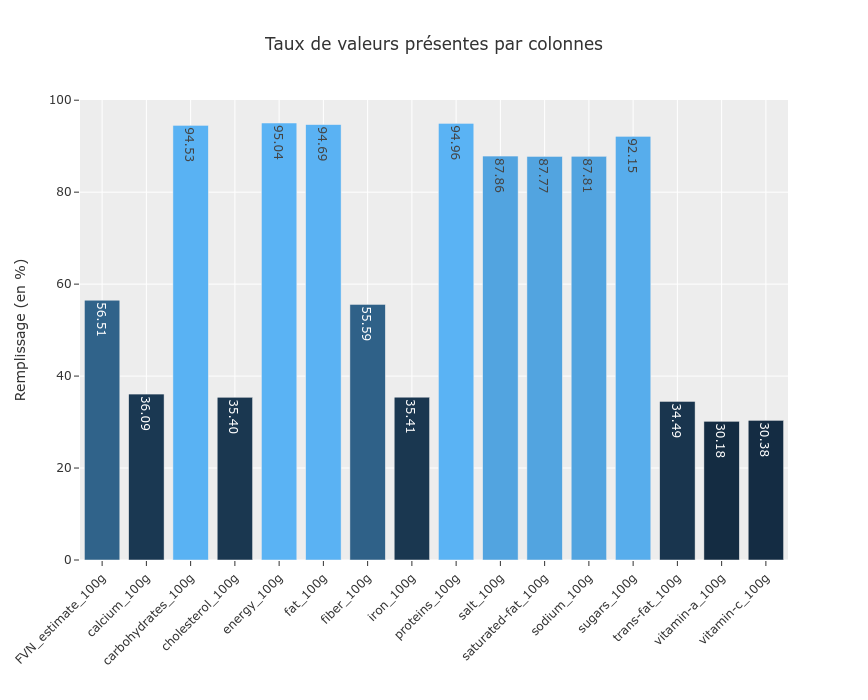

In [49]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=700,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
             text=[f"{x:.2f}" for x in fill_ratio_df.fill_rate],
            )

fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45)
fig.show()

### Etablissons une baseline pour nos imputations.
Pour ce faire, nous allons simplement imputer en utilisant les moyennes et calculer quelques scores.

In [50]:
data_imput_mean = data_tmp.copy()

#### 1. Sélectionnons quelques lignes dont les valeurs sont connues pour servir de valeurs de référence.

In [51]:
true_values_idx = {}
for col in var_nutri:
    true_values_idx[col] = data_tmp.dropna(subset=[col]).sample(frac=0.01, random_state=0).index

#### 2. Mettons ces lignes en None

In [52]:
for col in var_nutri:
    data_imput_mean.loc[true_values_idx[col] ,col] = None

#### 3. Appliquons la moyenne des colonnes sur tous les None (y compris ceux que l'on vient de créer artificiellement)

In [53]:
for col in var_nutri:
    mean = data_imput_mean[col].mean()
    data_imput_mean[col].fillna(mean, inplace=True)

#### 4. Calculons nos scores de référence *(baseline with dummy model)*

In [54]:
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
def print_scores(dt_true, dt_pred, eval_idx):
    r2_list = []
    rmse_list = []
    for col in var_nutri:
        true_v = dt_true.loc[eval_idx[col]][col]
        pred_v = dt_pred.loc[eval_idx[col]][col]
    
        r2 = r2_score( true_v , pred_v )
        rmse = mean_squared_error( true_v, pred_v, squared=False)
        
        r2_list.append(r2)
        rmse_list.append(rmse)
        
        print(f"{col.rjust(25)}  ==>  R²:{r2:8.2f} | RMSE:{rmse:8.2f}")
    
    r2_mean = sum(r2_list)/len(r2_list)
    rmse_mean = sum(rmse_list)/len(rmse_list)
    print(f"{'-'*115}\n{'MEAN'.rjust(25)}  ==>  R²:{r2_mean:8.2f} | RMSE:{rmse_mean:8.2f}")
        
    return r2_list, rmse_list

In [56]:
_, rmse_list_mean = print_scores(data_tmp, data_imput_mean, true_values_idx)

        FVN_estimate_100g  ==>  R²:   -0.01 | RMSE:   21.79
             calcium_100g  ==>  R²:   -0.06 | RMSE:    0.08
       carbohydrates_100g  ==>  R²:   -0.05 | RMSE:   24.57
         cholesterol_100g  ==>  R²:   -0.01 | RMSE:    0.03
              energy_100g  ==>  R²:   -0.00 | RMSE:  844.20
                 fat_100g  ==>  R²:   -0.00 | RMSE:   16.69
               fiber_100g  ==>  R²:   -0.04 | RMSE:    3.40
                iron_100g  ==>  R²:   -0.00 | RMSE:    0.00
            proteins_100g  ==>  R²:   -0.00 | RMSE:   13.24
                salt_100g  ==>  R²:   -0.01 | RMSE:   10.56
       saturated-fat_100g  ==>  R²:   -0.00 | RMSE:    8.78
              sodium_100g  ==>  R²:   -0.08 | RMSE:    0.67
              sugars_100g  ==>  R²:   -0.00 | RMSE:   22.31
           trans-fat_100g  ==>  R²:    0.00 | RMSE:    0.06
           vitamin-a_100g  ==>  R²:   -0.02 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:   -0.08 | RMSE:    0.01
----------------------------------------

### Imputation par IterativeImputer

Dans un IterativeImputer, les colonnes sont remplies par ordre croissant; de celles qui ont le moins de valeurs manquantes à celles qui en ont le plus. Il est donc inutile d'utiliser une autre méthode au préalable pour compléter les colonnes les mieux pourvues avant d'utiliser un IterativeImputer sur le reste.

In [57]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [58]:
data_imput_iter = data_tmp.copy()

#### 1. Mettons les lignes sélectionnées pour le calcul des scores en None *(on a repris une copie sans les imputations par les moyennes)*

In [59]:
for col in var_nutri:
    data_imput_iter.loc[true_values_idx[col] ,col] = None

In [60]:
X = data_imput_iter[var_nutri]
# y = data_input_iter['nutriscore_score']

#### 2. Définissons les valeurs maximales que l'IterativeImputer peut donner à chaque colonne.

In [61]:
max_values_imput = [100.0]*len(var_nutri)
for i, col in enumerate(var_nutri):
    if(col in max_values):
        max_values_imput[i] = max_values[col]

#### 3. Entrainons l'IterativeImputer et remplissons les trous

In [62]:
imputer = IterativeImputer(
    imputation_order='ascending', 
    random_state=0, 
    min_value=0, 
    max_value=max_values_imput
)
Xtrans = imputer.fit_transform(X)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P3/venvP3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [63]:
Xtrans = pd.DataFrame(Xtrans, columns=var_nutri, index=data_tmp.index)

#### 4. Calculons nos scores pour comparaison avec les scores obtenus avec les imputations par les moyennes

In [64]:
data_imput_iter_pre = data_imput_iter.copy()

In [65]:
data_imput_iter[var_nutri] = Xtrans

In [66]:
_, rmse_list_iter = print_scores(data_tmp, data_imput_iter, true_values_idx)

        FVN_estimate_100g  ==>  R²:    0.04 | RMSE:   21.31
             calcium_100g  ==>  R²:   -0.91 | RMSE:    0.10
       carbohydrates_100g  ==>  R²:    0.68 | RMSE:   13.57
         cholesterol_100g  ==>  R²:    0.08 | RMSE:    0.03
              energy_100g  ==>  R²:    0.89 | RMSE:  276.79
                 fat_100g  ==>  R²:    0.90 | RMSE:    5.28
               fiber_100g  ==>  R²:   -0.03 | RMSE:    3.39
                iron_100g  ==>  R²:    0.79 | RMSE:    0.00
            proteins_100g  ==>  R²:    0.57 | RMSE:    8.67
                salt_100g  ==>  R²:    1.00 | RMSE:    0.26
       saturated-fat_100g  ==>  R²:    0.61 | RMSE:    5.49
              sodium_100g  ==>  R²:    0.98 | RMSE:    0.10
              sugars_100g  ==>  R²:    0.74 | RMSE:   11.45
           trans-fat_100g  ==>  R²:    0.00 | RMSE:    0.06
           vitamin-a_100g  ==>  R²:    0.26 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:    0.51 | RMSE:    0.00
----------------------------------------

### Appliquons la méthode d'imputation la plus adaptée

#### 1. Comparons les scores obtenus avec l'IterativeImputer et les imputations par les moyennes

In [67]:
best_is_mean = []
for i in range(len(rmse_list_iter)):
    diff = rmse_list_iter[i] - rmse_list_mean[i]
    
    if diff > 0:
        best_is_mean.append(True)
        best = 'Mean'
    else:
        best_is_mean.append(False)
        best = 'IterativeImputer'
        
    print(f"{var_nutri[i].rjust(25)} | diff={diff:8.3f} | Best method: {best}")

        FVN_estimate_100g | diff=  -0.482 | Best method: IterativeImputer
             calcium_100g | diff=   0.026 | Best method: Mean
       carbohydrates_100g | diff= -10.993 | Best method: IterativeImputer
         cholesterol_100g | diff=  -0.001 | Best method: IterativeImputer
              energy_100g | diff=-567.404 | Best method: IterativeImputer
                 fat_100g | diff= -11.407 | Best method: IterativeImputer
               fiber_100g | diff=  -0.010 | Best method: IterativeImputer
                iron_100g | diff=  -0.001 | Best method: IterativeImputer
            proteins_100g | diff=  -4.574 | Best method: IterativeImputer
                salt_100g | diff= -10.309 | Best method: IterativeImputer
       saturated-fat_100g | diff=  -3.289 | Best method: IterativeImputer
              sodium_100g | diff=  -0.570 | Best method: IterativeImputer
              sugars_100g | diff= -10.868 | Best method: IterativeImputer
           trans-fat_100g | diff=   0.001 | Best m

> On constate que l'IterativeImputer a obtenu de meilleurs scores RMSE que l'imputation par la moyenne, pour toutes les colonnes.

#### 2. Remettons les valeurs originales que nous avions supprimées et imputées pour les évaluations

In [68]:
data_imput = data_imput_iter.copy()
for col in var_nutri:
    data_imput.loc[true_values_idx[col], col] = data_clean.loc[true_values_idx[col]][col]

#### 3. Vérifions la distribution avant et après imputation pour chaque colonne

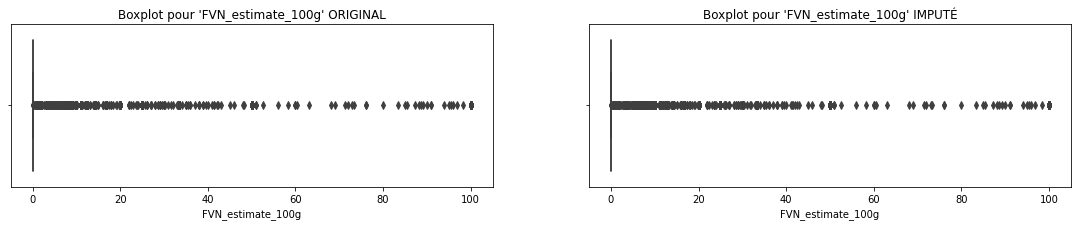

<function __main__.select_distrib(col)>

In [69]:
def select_distrib(col):
    fig = plt.figure(figsize=(19,3))

    ax = plt.subplot(1, 2, 1)
    sns.boxplot(x=data_tmp[col][data_tmp[col].notnull()])
    plt.title(f"Boxplot pour '{col}' ORIGINAL")
    
    ax = plt.subplot(1, 2, 2)
    sns.boxplot(x=data_imput_iter[col][data_tmp[col].notnull()])
    plt.title(f"Boxplot pour '{col}' IMPUTÉ")
    plt.show()

interact(select_distrib, col=var_nutri)

> Aucune des variables ne présente de différence significative.

#### Vérifions le remplissage des colonnes

In [70]:
fill_ratio = print_fill_rate(data_imput, var_nutri)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
---------------------------------------------------------------------------------------------------------------
 FVN_estimate_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
carbohydrates_100g |               0 |          100.00%
  cholesterol_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          

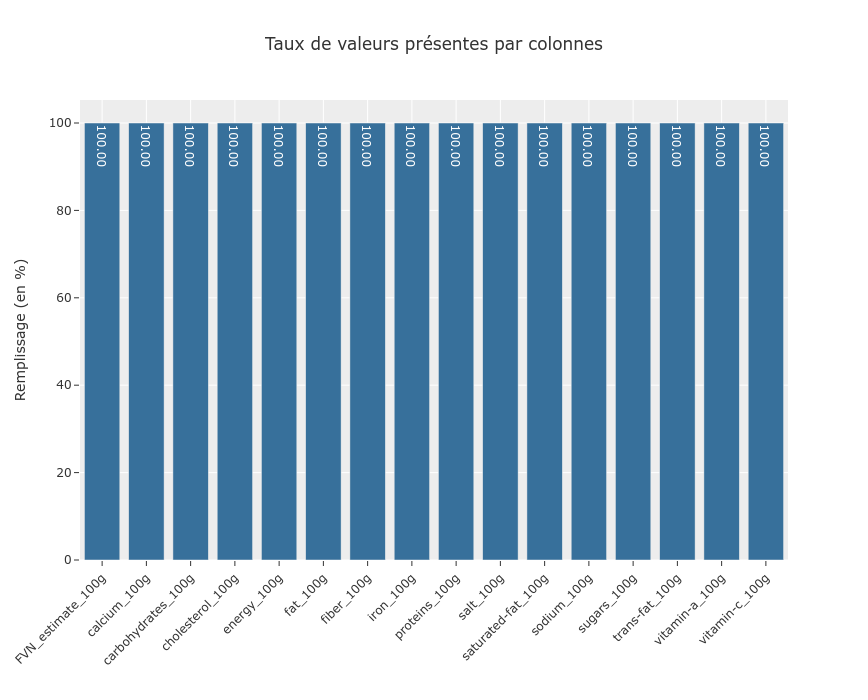

In [71]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=700,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
             text=[f"{x:.2f}" for x in fill_ratio_df.fill_rate],
            )

fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45)
fig.show()

In [72]:
data_clean = data_imput.copy()

## 4.4 Suppression des lignes dont les valeurs nutritionnelles ne sont pas logiques <a class="anchor" id="clean_logic"></a>

Certaines colonnes du jeu de données, sont en fait des sous catégories d'autres colonnes. Par exemple `fat_100g` contient également `trans-fat_100g`, `saturated-fat_100g` et `cholesterol_100g`. De même `carbohydrates_100g` contient `sugars_100g` et `salt_100g` contient `sodium_100g`.

### Sur la base de ces informations, vérifions si les colonnes des `_100g` ne dépassent pas certaines limites logiques

In [73]:
data_check = data_clean.copy()

#### 1. Supprimons les lignes dont le taux de `sugars_100g` dépasse celui des `carbohydrates_100g` *(avec une marge de tolérence)*

In [74]:
check_idx = data_check[(data_check.sugars_100g - data_check.carbohydrates_100g > 1) & (data_check.carbohydrates_100g > 0)].index

In [75]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 8546 lignes (10 lignes de moins)


#### 2. Supprimons les lignes dont le taux de `saturated-fat_100g` + `trans-fat_100g` + `cholesterol_100g` dépasse celui des `fat_100g` *(avec une marge de tolérence)*

In [76]:
check_idx = data_check[
    (
        data_check['saturated-fat_100g'] + \
        data_check['trans-fat_100g'] + \
        data_check['cholesterol_100g'] -\
        data_check['fat_100g'] > 1 
    ) & (data_check['fat_100g'] > 0)
    ].index

In [77]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 8500 lignes (46 lignes de moins)


#### 3. Supprimons les lignes dont le taux de `sodium_100g` x 2.45, dépasse celui du `salt_100g` *(avec une marge de tolérence)*

In [78]:
check_idx = data_check[(data_check.sodium_100g * 2.45 - data_check.salt_100g > 0) & (data_check.salt_100g > 0)].index

In [79]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 8500 lignes (0 lignes de moins)


#### 4. Supprimons les lignes dont la sommes des principales catégories dépasse les 100g *(avec une marge de tolérence)*

In [80]:
check_idx = data_check[
    (
        data_check['carbohydrates_100g'] + \
        data_check['fat_100g'] + \
        data_check['proteins_100g'] + \
        data_check['salt_100g'] + \
        data_check['fiber_100g'] + \
        data_check['calcium_100g'] + \
        data_check['vitamin-a_100g'] + \
        data_check['vitamin-c_100g'] + \
        data_check['iron_100g'] - 100 > 1
    )
    ].index

In [81]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 7685 lignes (815 lignes de moins)


In [82]:
data_clean = data_check.copy()

# 5. Démarche méthodologique d'analyse de données <a class="anchor" id="P05"></a>

## 5.1 Analyses univariées des variables <a class="anchor" id="analysis_univariate"></a>

Le but d'une analyse univariée est de décrire les données pour en découvrir les caractéristiques et mieux les comprendre. Pour ce faire, on examine la moyenne, le mode, la médiane, l'écart type, la dispersion, etc. par le biais d'histogrammes, de tableaux de distribution de fréquence, de diagrammes à barres, ou autres.

In [83]:
vars_quantitatives = data_nutri.select_dtypes(include=np.number).columns
vars_qualitatives = data_nutri.select_dtypes(exclude=np.number).columns

In [84]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm #, uniform

In [85]:
# Définissons une fonction permettant d'explorer les colonnes numériques

def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(dt.describe())
    
    fig = plt.figure(figsize =(15, 10))
    
    ax = plt.subplot(2, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")
    
    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")
    
    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot pour {col_name}")
    qqplot(data_clean[data_clean[col].notnull()][col], norm, fit=True, line="45", ax=ax)
    
    ### Missing
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null
     
    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Répartition entre produits avec ou sans '{col_name}'")
    plt.legend([f"Produits sans '{col_name}'", f"Produits avec '{col_name}'"], loc='lower center', bbox_to_anchor=(0, 0))
    
    fig.tight_layout()
    plt.show()
    
    print(f"Il manque {total_size_null} sur {total_size} dans la colonne '{col_name}' ({percent_v:.2f}%)")
    
    print("""
On note que cette variable présente de nombreuses valeurs atypiques. Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.

Par ailleurs, il ne manque aucune valeur puisque c'est une colonne que nous avons imputé préalablement.

Enfin, on note que la distribution n'est pas *normale*.

RECOMMANDATIONS: faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.
    """)

In [86]:
# Définissons une fonction permettant d'afficher la répartition des données (sans pie-chart)

def display_fraction(data, col_name, title, ylabel="Remplissage (en %)", showscale=True, showtext=True):
    dt = data[col_name]

    fig = px.bar(dt, y=col_name, 
             #width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [87]:
# Définissons une finction permettant d'afficher quelques informations sur le remplissage d'UNE colonne

def show_missing(data, col_name):
    
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null
    
    print(f"Il manque {total_size_null} sur {total_size} dans la colonne '{col_name}' ({percent_v:.2f}%)")
    
    fig = plt.figure(figsize=[15,5])

    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Répartition entre produits avec ou sans '{col_name}'")
    plt.legend([f"Produits sans '{col_name}'", f"Produits avec '{col_name}'"], loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [88]:
def explore_code(data):
    
    #### Regardons la répartition de ces valeurs
    
    vcount = data['code'].str.len().value_counts(dropna=True)
    select_count = pd.DataFrame(vcount)

    # On calcul le pourcentage
    select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'code':'Quantité'}, inplace=True)

    # On selectionne les 25 premiers
    select_count = select_count[:20]

    display_fraction(select_count, 'Quantité', 
                 "Répartition des code-barres selon leur taille", 
                 showscale=True, showtext=True)

    #### Regardons le nombre de code-barres entièrement composés de chiffres *(donc sans lettres)*
    
    digit_v = data_clean['code'].str.isdigit().sum()
    percent_v = 100/data_clean.shape[0]*digit_v

    print(f"Il y a {digit_v} code-barres entièrement composés de chiffres ({percent_v:.2f}%)")
    
    #### Valeurs manquantes
    
    show_missing(data, 'product_name')
    
    #### Conclusion
    
    print("""
On a donc 1 code-barre unique pour chaque ligne du jeu de données (chaque code-barre est unique et aucun produit n'est pas de code-barre).

Le format bien que toujours composé de chiffres, n'est pas un format unique (on trouve des code de longueur 1 à 56). Cependant on constate que la grande majorité des `codes` sont au format EAN-13 (93.1%) puis EAN-8 (5.1%).

Nous avions gardé cette colonne pour aider à la suppression des doublons et c'est chose faite, elle ne présente donc plus d'autre intérêt que de rechercher un produit via son code-barre.
 
RECOMMANDATIONS: la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.
    """)

In [89]:
def explore_product_name(data):
    
    #### Regardons la répartition de ces valeurs
    
    vcount = data['product_name'].value_counts(dropna=True)
    select_count = pd.DataFrame(vcount)

    # On calcul le pourcentage
    #select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'product_name':'Quantité'}, inplace=True)

    # On selectionne les 25 premiers
    select_count = select_count[:25]

    display_fraction(select_count, 'Quantité', 
                 "Top 25 des noms de produits les plus communs", 
                 showscale=True, showtext=True)
    
    #### Combien de produits ont un nom unique ? 
    
    unique_v = data['product_name'].isin(vcount.index[vcount<=1.0]).sum()
    percent_v = 100/data.shape[0]*unique_v

    print(f"Il y a {unique_v} noms de produits ne correspondant qu'à un seul produit ({percent_v:.2f}%)")
    
    #### Valeurs manquantes
    
    show_missing(data, 'code')
    
    #### Conclusion
    
    print("""
Si la majorité des produits sont uniques (60.05%), de nombreux produits sont malgré tout associés au même nom. Ce n'est pas vraiment étonnant, car on peut avoir des noms très générique *(par exemple le mode est ici "Ice cream" avec 717 instances)* avec des valeurs nutritionnelles différentes.

On note d'ailleurs que malgré le nettoyage fait au préalable, il reste environ 8600 produits sans nom...

RECOMMANDATIONS: la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.
    """)

In [90]:
def explore_pnns_groups_2(data):
    
    #### Regardons la répartition de ces valeurs
    
    vcount = data['pnns_groups_2'].value_counts(dropna=True)
    select_count = pd.DataFrame(data['pnns_groups_2'].value_counts(dropna=True))

    # On calcul le pourcentage
    select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'pnns_groups_2':'Pourcentage'}, inplace=True)

    # On selectionne les 25 premiers
    select_count = select_count[:25]

    display_fraction(select_count,
                     'Pourcentage', "Repartition (en % des non-nulls) de produits par catégories principales (Top 25 uniquement & hors None)", 
                     showscale=True, showtext=True)
        
    #### Valeurs manquantes
    
    show_missing(data, 'pnns_groups_2')
    
    #### Conclusion
    
    print("""
Les sucreries (Sweets), biscuits et gateaux (Biscuits and cakes) prennent une place importante.

Les produits bruts comme la viande (Meat), le poisson (Fish and seafood), les légumes (Vegetables) ou les fruits (Fruits) sont moins bien représentés.

RECOMMANDATIONS: on peut essayer d'imputer cette colonne avec un KNN.
    """)

In [91]:
def explore_nutriscore_grade(data):
    #### Regardons la répartition de ces valeurs
    
    vcount = data['nutriscore_grade'].value_counts(dropna=True).sort_index()
    select_count = pd.DataFrame(vcount)

    # On calcul le pourcentage
    select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'nutriscore_grade':'Pourcentage'}, inplace=True)

    display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nutri-grades (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)
    
    #### Valeurs manquantes
    
    show_missing(data, 'nutriscore_grade')
    
    #### Conclusion
    
    print("""
Si la majorité des grades ne sont pas renseignés (63.66%), on constate quand ils le sont beaucoup de D (30.5%), peu de B (13.8%) et modèrement du reste (A: 15.9%, C: 21.4%, E: 18.4%).

Il est très probable que l'on retrouve une répartition similaire dans la colonne nutriscore_score (c'est juste après).

RECOMMANDATIONS: explorer la relation entre nutriscore_score et nutriscore_grade lors des analyses multivariées.
    """)

In [92]:
data_clean['nutriscore_grade'] = data_clean['nutriscore_grade'].str.upper()

count                     7685
unique                    7685
top       00000000000003429145
freq                         1
Name: code, dtype: object


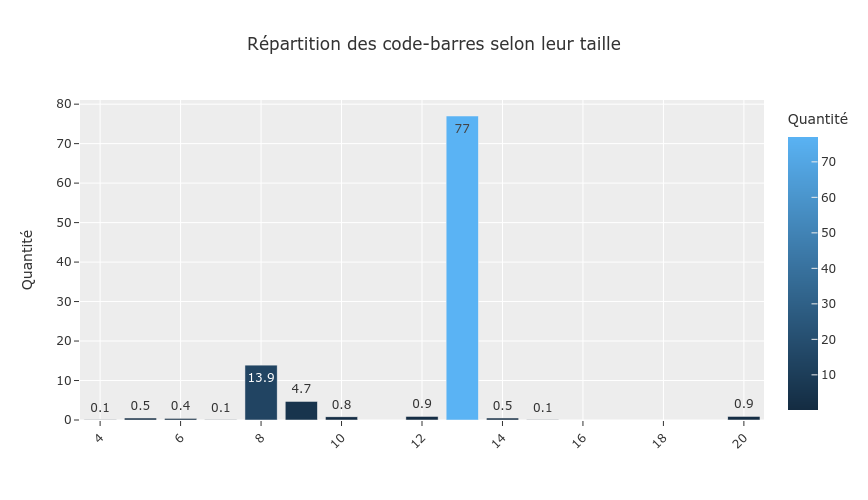

Il y a 7685 code-barres entièrement composés de chiffres (100.00%)
Il manque 4 sur 768 dans la colonne 'product_name' (0.52%)


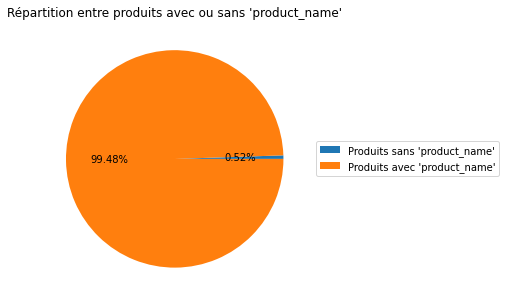


On a donc 1 code-barre unique pour chaque ligne du jeu de données (chaque code-barre est unique et aucun produit n'est pas de code-barre).

Le format bien que toujours composé de chiffres, n'est pas un format unique (on trouve des code de longueur 1 à 56). Cependant on constate que la grande majorité des `codes` sont au format EAN-13 (93.1%) puis EAN-8 (5.1%).

Nous avions gardé cette colonne pour aider à la suppression des doublons et c'est chose faite, elle ne présente donc plus d'autre intérêt que de rechercher un produit via son code-barre.
 
RECOMMANDATIONS: la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.
    


<function __main__.select_var(col)>

In [93]:
def select_var(col):
    
    data_sample = data_clean.sample(frac=0.1)
    # describe
    
    # graphiques pour variables quantitatives
    if col in data_clean.select_dtypes(include='number'):
        explore_quantitative(data_sample, col)
    else:
        print(data_clean[col].describe())
        if col == 'code':
            explore_code(data_sample)
        elif col == 'product_name':
            explore_product_name(data_sample)
        elif col == 'pnns_groups_2':
            explore_pnns_groups_2(data_sample)
        elif col == 'nutriscore_grade':
            explore_nutriscore_grade(data_sample)
        
    #return col
    
interact(select_var, col=data_clean.columns)

## 5.2 Analyses multivariées <a class="anchor" id="analysis_multivariate"></a>

Les analyses multivariées ont pour vocation de mettre en évidence des informations sur les relations entre variables. Mais sans objectif on peut croiser beaucoup de données sans vraiment savoir ce que l'on cherche...

On va vu que la [documentation du nutriscore](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.


#### Hypothèse
> Nous allons donc essayer de **vérifier par des analyses bivariées et multivariées, si des colonnes pouvant correspondre à ces éléments favorables ou défavorables le sont effectivement au regard de `nutriscore_score` et de `nutriscore_grade`**.

> Voici donc les objectifs pour lesquels il serait utile d'avoir des informations:
> 1. Vérifier la relation entre `nutriscore_score` et les divers indicateurs des nutriments.
> 2. Vérifier la relation entre `nutriscore_grade` et les divers indicateurs des nutriments.
> 3. Vérifier la relation entre `nutriscore_score` et `nutriscore_grade`
> 4. Vérifier la relation entre `nutriscore_grade` et `pnns_groups_2` *(ça ne sert pas l'hypothèse, mais ça pourrait être intéressant)*

---

### 5.2.0 Commençons par vérifier les corrélations entre toutes les variables

#### Re-vérifions les indices de corrélation entre les variables `numériques` après imputations & nettoyage. <a class="anchor" id="P03_correlation_num"></a>

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.


Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

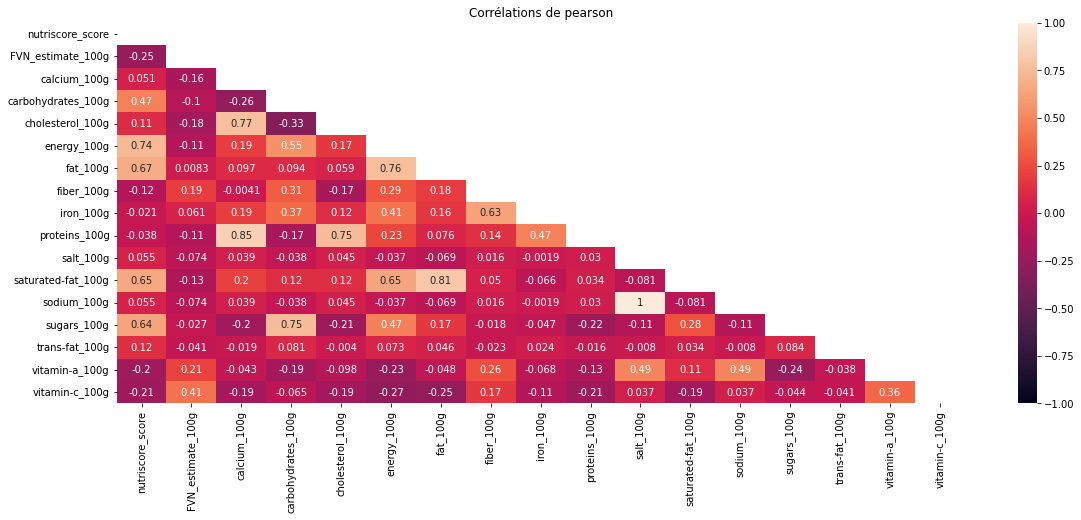

<function __main__.show_correlation2(cor_name)>

In [94]:
data_corr_2 = data_clean.sample(frac=0.1).copy()

def show_correlation2(cor_name):
    
    fig = plt.figure(figsize=(19,7))
    corr= data_corr_2.corr(method=cor_name)
    matrix = np.triu(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
    ax.set_title(f'Corrélations de {cor_name}')
    #ax.legend()
    
    plt.show() 

interact(show_correlation2, cor_name=["pearson", "spearman"])

> Nous avions [déjà vérifié ces indices](#clean_correlations) de corrélation avant le nettoyage des données. Mais on constate que le nettoyage a légèrement modifié ces données.
>
> - La plus part des indices restent sensiblement les même avec une lègère augmentation ou diminution.
> - On note l'apparition d'une forte corrélation entre le `calcium_100g` et le `cholesterol_100g`.
> - La colonne `vitamin-c_100g` qui étaient corrélée très peu de colonnes l'est à présent avec la plupart.
> - `fiber_100g` et `iron_100g`, `proteins_100g` et `calcium_100g` ou encore `proteins_100g` et `cholesterol` qui étaient modèrement corrélées, le sont à présent fortement.
>
> **Dans l'ensemble on note qu'après le nettoyage les corrélations sont plus marquées qu'avant.**

#### Puis vérifions les indices de corrélation entre les variables `numériques` et `nominales`.
                                                                                   
Pour permettre de vérifier simplement la corrélation entre les variables numériques et les variables nominales, nous allons utiliser un LabelEncoder sur les colonnes nominales qui nous intéressent puis calculer à nouveau les corrélations linéaires et monotones.<br>(On pourrait aussi calculer $\eta^2$ à partir d'une ANOVA)

In [95]:
data_corr = data_clean.copy()

In [96]:
from sklearn.preprocessing import LabelEncoder

In [97]:
cats = ['pnns_groups_2', 'nutriscore_grade', 'nova_group']

for cat in cats:
    encoder=LabelEncoder()
    encoder.fit(data_corr[cat])
    data_corr[f"{cat}_enc"]=encoder.transform(data_corr[cat])

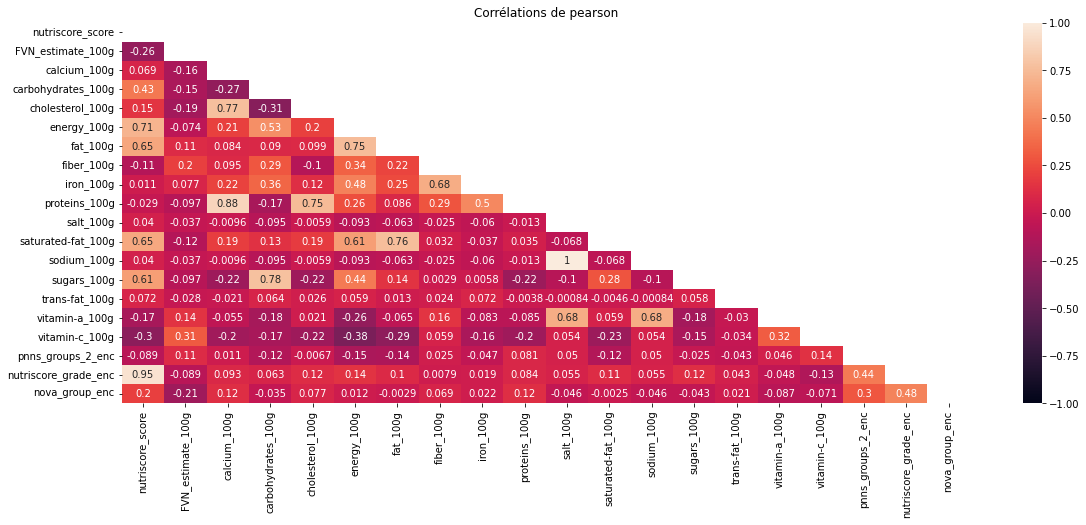

<function __main__.show_correlation3(cor_name)>

In [98]:
data_corr_3 = data_corr.sample(frac=0.1).copy()

def show_correlation3(cor_name):
    
    fig = plt.figure(figsize=(19,7))
    corr= data_corr_3.corr(method=cor_name)
    matrix = np.triu(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
    ax.set_title(f'Corrélations de {cor_name}')
    #ax.legend()
    
    plt.show() 

interact(show_correlation3, cor_name=["pearson", "spearman"])

> Comme attendu on constate une forte corrélation entre le `nutriscore_score` et `nutriscore_grade_enc`.
>
> On constate également plusieurs corrélations faibles entre `nutriscore_grade_enc` et les divers indicateurs nutritionnels, mais elles sont nettement moins prononcées qu'avec `nutriscore_score`.
>
> En revanche, `nutriscore_grade_enc` *(tous comme `nova_group_enc`)* semble moyennement corrélée avec les catégories de produits `pnns_groups_2`.
>
> Enfin, si les trois variables nominales encodées sont visiblement toutes modérement corrélées entre elles, on note que `nova_group_enc` et `pnns_groups_2_enc` ne semblent pas particulièrement sensible aux variables des nutriments.

---

#### Enfin vérifions les indices de corrélation entre les variables `nominales`. <a class="anchor" id="P03_correlation_nom"></a>

Pour ce faire, nous allons utiliser le test V de Cramer.<br>
C'est une mesure d'association entre deux variables nominales, qui est basée sur le Chi-squared de Pearson.<br>
Elle donne une valeur comprise entre 0 et +1 (inclus)
- 0 : il n'y a visiblement aucune relation entre les variables.
- 1 : il y a une relation parfaite entre les variables (on ne peut atteindre 1 que lorsque chaque variable est complètement déterminée par l'autre).

In [100]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

vars_ = ['nutriscore_grade', 'nova_group', 'pnns_groups_2']

corr = []
for v1 in vars_:
    corr2 = []
    for v2 in vars_:
        confusion_matrix = pd.crosstab(data[v1], data[v2])
        cramer_score = cramers_v(confusion_matrix.values)
        #print(f"{v1} / {v2} -> {cramer_score}")
        corr2.append(cramer_score)
    corr.append(corr2)
    
corr = pd.DataFrame(corr)
corr.index = corr.columns = vars_

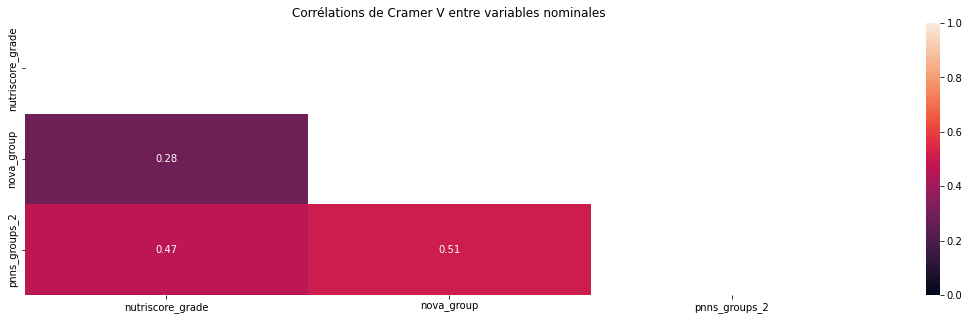

In [101]:
fig = plt.figure(figsize=(19,5))

matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=0, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Cramer V entre variables nominales')

plt.show()

> Le `nutriscore_grade` n'est que peu corrélé au `nova_group`, mais on constate en revanche que ces deux systèmes de classifications sont assez corrélés aux catégories de produits `pnns_groups_2`, comme nous l'avions déjà constatés un peu plus haut avec les corrélations de Pearson et Spearma en encodant ces variables.

### 5.2.1 Vérifions les relations entre `nutriscore_score` et les variables des nutriments
avec des `régressions linéaires` et le `coéfficient de détermination R²`

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [102]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample = data_clean.sample(frac=0.1, random_state=0)
data_sample.dropna(inplace=True)

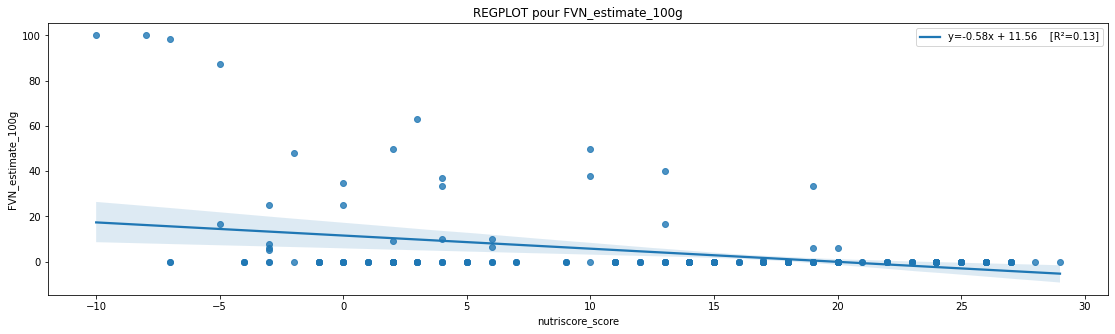

<function __main__.select_regplot2(col)>

In [103]:
data_regplot2 = data_sample.copy()

def select_regplot2(col):
    fig = plt.figure(figsize=(19,5))

    slope, intercept, r_value, pv, se = stats.linregress(data_regplot2['nutriscore_score'], data_regplot2[col])
    sns.regplot(x="nutriscore_score", y=col, data=data_regplot2, line_kws={'label':f"y={slope:.2f}x + {intercept:.2f}    [R²={r_value**2:.2f}]"})
    #sns.jointplot(x="nutriscore_score", y=col, data=data_clean.sample(frac=0.01), kind="reg")#, stat_func=r2)
    plt.title(f"REGPLOT pour {col}")
    plt.legend()

    plt.show()

interact(select_regplot2, col=var_nutri)

> On constate que **les coéfficients de détermination R² se sont globalement affaiblis** par rapport à la [première exploration](#clean_linear) faite avant le nettoyage et les imputations, mais **dans l'ensemble les tendances sont les mêmes**.
>
> - `energy_100g`:        son **R² baisse** de 0.44 à **0.35**
> - `saturated-fat_100g`: son **R² baisse** de 0.43 à **0.35**
> - `sugars_100g`:        son **R² baisse** de 0.28 à **0.22**
> - `FVN_estimate_100g`:  son **R² baisse** de 0.08 à **0.06**
> - `salt_100g`:          son **R² baisse** de 0.07 à **0.04**
> - `fiber_100g`:         son **R² baisse** de 0.04 à **0.02**
> - `proteins_100g`:      son **R² reste stable** à **0.01**
> - `fat_100g`:           son **R² baisse** de 0.36 à **0.25**
> - `carbohydrates_100g`  son **R² baisse** de 0.10 à **0.07**
> - `cholesterol_100g`    son **R² augmente** de 0.08 à **0.09**
> - `sodium_100g`         son **R² baisse** de 0.07 à **0.04**
> - `calcium_100g`        son **R² augmente** de 0.03 à **0.06**
> - `vitamin-c_100g`      son **R² augmente** de 0.02 à **0.07**
>
> Cette diminution des R² s'explique par le fait que les imputations ont crée des valeurs moins reserrées autour des lignes de regressions.

### 5.2.2 Vérifions les relations entre `nutriscore_grade` et les variables des nutriments

In [104]:
mean_nutri = []
grades = ['A','B','C','D','E']
for grade in grades:
    mean_nutri.append(list(data_clean[data_clean.nutriscore_grade == grade][var_nutri].mean(numeric_only=True)))

mean_nutri_pd = pd.DataFrame(mean_nutri, columns=var_nutri, index=grades)
mean_nutri_pd.drop(['energy_100g'], axis=1, inplace=True)

# On transforme en %
sum_nutri_pd = mean_nutri_pd.sum()
mean_nutri_pd = 100/sum_nutri_pd*mean_nutri_pd
mean_nutri_pd

,FVN_estimate_100g,calcium_100g,carbohydrates_100g,cholesterol_100g,fat_100g,fiber_100g,iron_100g,proteins_100g,salt_100g,saturated-fat_100g,sodium_100g,sugars_100g,trans-fat_100g,vitamin-a_100g,vitamin-c_100g
A,43.574,18.863,13.723,13.008,4.826,27.875,21.118,22.563,5.601,2.128,5.604,5.531,8.292,26.391,35.102
B,18.566,17.462,12.984,16.850,7.331,16.104,17.801,18.592,12.960,4.473,12.967,6.894,11.910,17.823,19.884
C,21.400,14.877,16.664,15.748,13.291,20.888,19.345,16.976,39.050,7.146,39.021,12.580,17.574,23.197,24.667
D,12.218,27.292,25.676,29.088,28.184,18.716,22.086,24.389,24.539,25.936,24.550,28.269,34.066,17.611,11.961
E,4.242,21.507,30.953,25.306,46.368,16.416,19.649,17.480,17.850,60.317,17.858,46.727,28.158,14.978,8.386


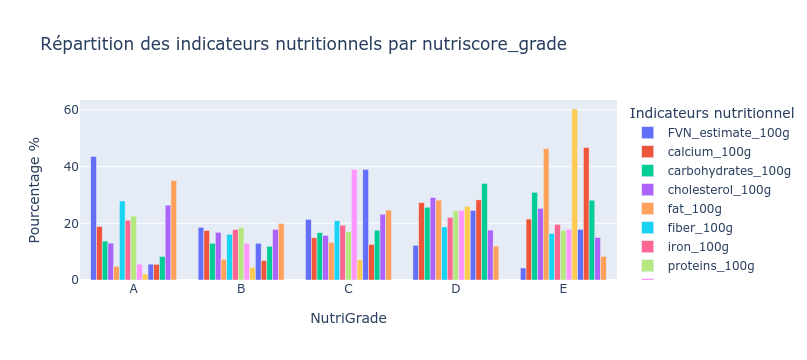

In [105]:
fig = px.bar(
    title="Répartition des indicateurs nutritionnels par nutriscore_grade",
    data_frame=mean_nutri_pd,
    #x="", y="", color="",
    barmode='group',
    labels={
        "variable": "Indicateurs nutritionnels",
        "index": "NutriGrade",
        "value": "Pourcentage %"
    },
    width=1000,
)

fig.show()

> En isolant les colonnes une à une *(clique sur les noms)*, on constate 4 types de tendances:
>
> - Celles qui tendent à augmenter avec le grade *(de A vers E)*; <br>`calcium_100g`, `carbohydrates_100g`, `cholesterol_100g`, `fat_100g`, `saturated-fat_100g`.
>
> - Celles qui tendent à augmenter avec le grade, mais avec un maximum sur D au lieu de E; <br>`salt_100g`, `sodium_100g`.
>
> - Celles qui tendent à baisser avec le grade, mais avec un rebond en C; <br>`FVN_estimate_100g`, `fiber_100g`
>
> - Et celles qui tendent à rester assez neutres vis à vis des différents grades *(il peut y avoir un grade plus présent qu'un autre, mais c'est assez peu marqué)*.

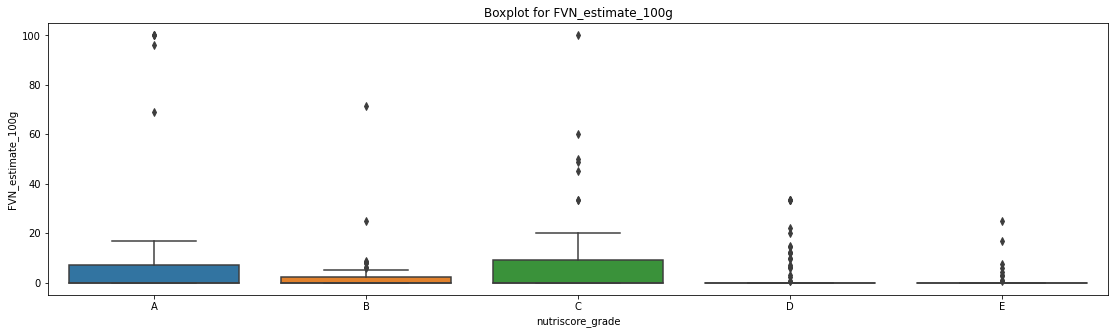

<function __main__.select_boxplot1(col)>

In [107]:
data_boxplot1 = data_clean.sample(frac=0.1).copy()

def select_boxplot1(col):
    fig = plt.figure(figsize=(19,5))

    sns.boxplot(data=data_boxplot1, x='nutriscore_grade', y=col, order='ABCDE')
    plt.title(f"Boxplot for {col}")

    plt.show()

interact(select_boxplot1, col=[*var_nutri, 'nutriscore_score'])

> Comme vu dans la seconde table de corrélation de la partie 5.2.0, les différentes colonnes de valeurs nutritionnelles présentes divers un moindre degrès de corrélation avec la colonne `nutriscore_grade` qu'avec la colonne `nutriscore_score`. Cette tendance se vérifie une fois encore avec les box-plots ci-dessus; les corrélations ne sont pas flagrantes.
>
> Il semble donc plus intéressant d'essayer de prédire le `nutriscore_score` plutôt que le `nutriscore_grade`.

### 5.2.3 Vérifions la relation entre `nutriscore_grade` et `nutriscore_score`

> Sur ce boxplot `nutriscore_score` vs `nutriscore_grade`, on perçoit immédiatement une relation forte.
>
> La documentation indique les plages suivantes pour les aliments:
> - [-15;-1] pour le **A**
> - [0;2] pour le **B**
> - [3;10] pour le **C**
> - [11;18] pour le **D**
> - [19;40] pour le **E**
>
> La documentation indique les plages suivantes pour les boissons:
> - Uniquement l'eau pour le **A**
> - [-15;1] pour le **B**
> - [2;5] pour le **C**
> - [6;9] pour le **D**
> - [10;40] pour le **E**
>
> On remarque des outliers, mais on constate que ces valeurs semblent majoritairement respectées.

Une autre façon de vérifier la relation entre ces deux colonnes et de regarder comment elles réagissent ensemble au regard des valeurs nutritionnelles...

#### Affichons donc un graphique permettant de confronter chaque variable nutritionnelles à `nutriscore_score` et `nutriscore_grade`.

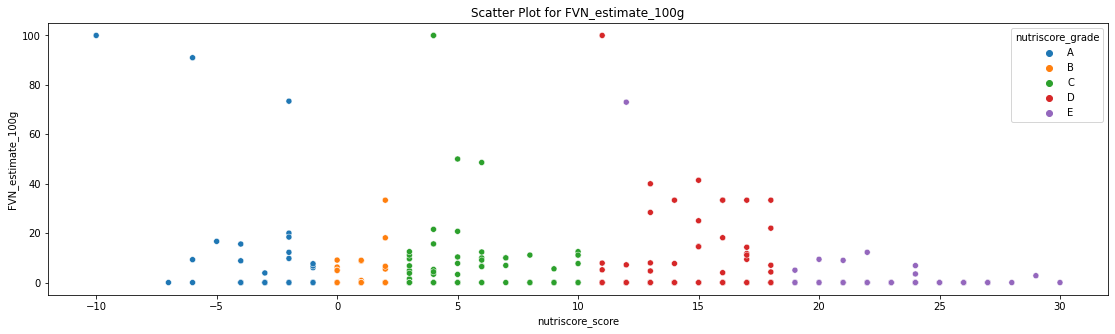

<function __main__.select_boxplot2(col)>

In [112]:
data_boxplot2 = data_clean.sample(frac=0.1).copy()

def select_boxplot2(col):
    fig = plt.figure(figsize=(19,5))

    sns.scatterplot(x=data_boxplot2['nutriscore_score'], y=data_boxplot2[col], hue=data_boxplot2['nutriscore_grade'], hue_order='ABCDE')
    plt.title(f"Scatter Plot for {col}")

    plt.show()

interact(select_boxplot2, col=[*var_nutri, 'nutriscore_score'])

> Si on se concentre purement sur la relation entre le `nutriscore_score` et le `nutriscore_grade`, on peut voir que la distribution du `nutriscore_grade` semble globalement respecter le positionnement escomptée sur l'échelle des le `nutriscore_score`.
>
> Il y a bien quelques `grades` en dehors des `scores` attendus, mais c'est un phénomènes assez restreint qui semble surtout toucher le groupe **E** *(qui déborde sur le groupe **D**)* et dans une moindre mesure le groupe **D** *(qui déborde sur le groupe **C**)*.

> Si on compare le `nutriscore_score` et le `nutriscore_grade` avec les colonnes des indicateurs nutritionnels, on remarque que certaines colonnes ne sont visuellement pas corrélées avec elles, alors que d'autres en revanches très marquées dans leur distribution. C'est le cas pour :
>
> - `sugars_100g` *(faible en A, fort en E)*
> - `energy_100g` *(faible en A, fort en E)*
> - `saturated_fat_100g` *(faible en A, fort en E)*
> - `fat_100g` *(faible en A, fort en E)*
> - `FVN_estimate_100g` *(fort en A, faible en E)*
> - `fiber_100g` *(fort en A, faible en E)*
> - `salt_100g` *(faible en A et D et plus fort en B, C, D)*
> - `sodium_100g` *(faible en A et D et plus fort en B, C, D)*
> - `proteins_100g` *(faible en A et D et plus fort en B, C, D)*
>
> Ces colonnes sont certainement les plus intéressantes pour préparer un modèle de prédiction du `nutriscore_score` et donc du `nutriscore_grade`. On remarque d'ailleurs que ce sont à peu près les colonnes que l'on a identifiées comme indéressantes en regard de la documentation du Nutriscore.

### 5.2.4 Vérifions les relations `pnns_groups_2` vs `nutriscore_score` et `nutriscore_grade`

#### Regardons la répartition des catégories `pnns_groups_2` sur les différents grade de `nutriscore_grade`

In [ ]:
data_bargraph1 = data_clean.sample(frac=0.1).copy()

def select_bargraph1(num_cats):
    top_categories = list(data_bargraph1['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

    #--- prepare data
    #data_tmp = data_clean.copy()
    #data_tmp['category'] = data_tmp['pnns_groups_2']
    #data_tmp.loc[~data_tmp['pnns_groups_2'].isin(top_categories),'category'] = 'OTHERS'
    #top_categories.append('OTHERS')

    #--- select data
    selection = data_bargraph1.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
    selection.rename(columns={0:'count'}, inplace=True)
    data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

    #--- graph
    fig = px.bar(data_graph, 
             x="nutriscore_grade",
             y="count",
             color="pnns_groups_2",
             title=f"Répartition des produits des {num_cats} catégories principales dans les Nutri-grades",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'nutriscore_grade': ['a','b','c','d','e']},
             height=700,
             width=1000,
            )
    fig.show()

interact(select_bargraph1, num_cats=widgets.IntSlider(min=1, max=40, step=1, value=25));

En explorant ce graphique interactif, on constate que :

> Le `grade A` semble contenir des **aliments bruts**; *légumes*, *céréales*, *fruits*, *viandes*, *poissons* et *produits laitiers*. Mais aussi **quelques produits transformés** comme des *plats-cuisinés* et *sucreries* qui sont plus surprenants.

> Le `grade B` semble contenir des **aliments bruts** et des **produits transformés**; *plats-cuisinés*, *produits-laitiers*, *viandes*, *poissons*, *céréales**, *pains*...

> Le `grade C` semble contenir des **produits bruts gras** et des **produits transformés**; *plats-cuisinés*, *huiles*, *sauces*, *biscuits & cakes*, *sucreries*, *viandes transformées* mais aussi quelques *viandes* et *poissons*...

> Le `grade D` semble contenir des **produits transformés gras / sucrés / salés**; *fromages*, *bicuits & cakes*, *sucreries*, *viandes transformées*, *poissons*, *sauces*, ...

> Le `grade E` semble contenir des **produits transformés gras / sucrés / salés** plus orientés encas; *biscuits & cakes*, *sucreries*, *viandes transformées*, *chocolats*, *boissons sucrées*...

#### Regardons à présent pour chacune de ces catégories `pnns_groups_2` leur répartition dans les `nutriscore_grade`

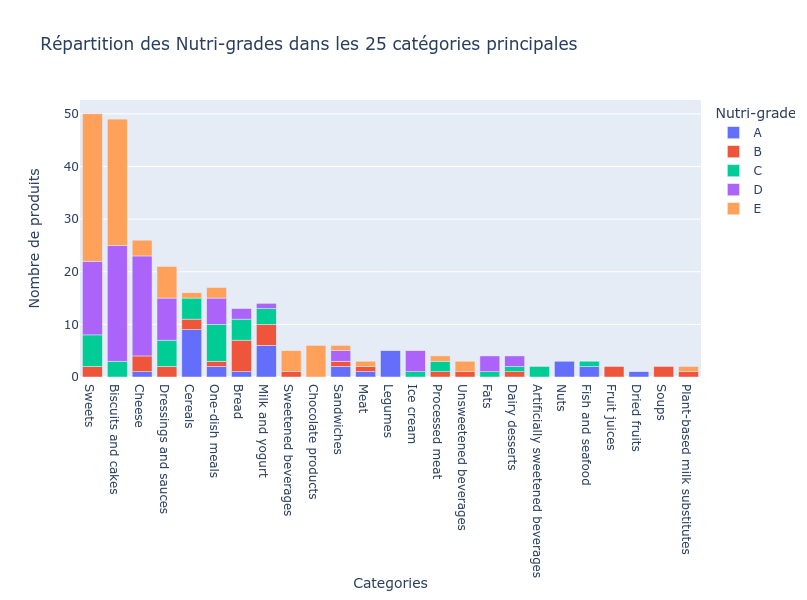

In [110]:
data_bargraph2 = data_clean.sample(frac=0.1).copy()

def select_bargraph2(num_cats):
    top_categories = list(data_bargraph2['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

    #--- select data
    selection = data_bargraph2.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
    selection.rename(columns={0:'count'}, inplace=True)
    data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

    #--- graph
    fig = px.bar(data_graph, 
             x="pnns_groups_2",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades dans les {num_cats} catégories principales",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'pnns_groups_2': top_categories},
             height=600,
             width=1000,
            )
    fig.show()

interact(select_bargraph2, num_cats=widgets.IntSlider(min=1, max=40, step=1, value=25));

Si l'on prend quelques catégories emblématiques, on constate que le classement est assez cohérant avec ce que l'on à découvert plus haut *(tendances à monter en grade de A vers E, avec le sucre, le gras, le sel...)*

> Les `Vegetables` *(légumes)* sont essentiellement classés `A`.

> Les `Milk and yogurt` *(lait & yahourts)* sont essentiellement classés `B` et `C`

> Les `Sweets` *(sucreries)* sont essentiellement classés `D` et `E`.

### Conclusion des analyses multivariées


> Sur la base de la **documentation NutriScore**, il faudrait sélectionner les colonnes suivantes:
>
> *Éléments défavorables au score:*
> 
> - `energy_100g` << *Apport calorique pour cent grammes*
> - `saturated-fat_100g` << *Teneur en graisses saturées*
> - `sugars_100g` << *Teneur en sucre*
> - `salt_100g` << *Teneur en sel*
>
> *Éléments favorables au score:*
>
> - `FVN_estimate_100g` << *Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive*
> - `fiber_100g`  << *Teneur en fibres*
> - `proteins_100g` << *Teneur en protéines*

> Sur la base des **tables de corrélations**, il faudrait sélectionner les colonnes suivantes:
>
> - `saturated-fat_100g` = 0.58 / 0.64
> - `energy_100g` = 0.58 / 0.60
> - `fat_100g` = 0.47 / 0.59
> - `sugars_100g` = 0.43 / 0.33
> - `carbohydrates_100g` = 0.24 / 0.18
> - `cholesterol_100g` = 0.19 / 0.26
> - `sodium_100g` = 0.16 / 0.34
> - `salt_100g` = 0.15 / 0.34
> - `vitamin-c_100g` = -0.13 / -0.27
> - `fiber_100g` = -0.17 / -0.2
> - `FVN_estimate_100g` = -0.24 / -0.19

> Sur la base des **coefficients de détermination R²** des régressions linéaires opposant `nutriscore_score` aux différentes colonnes nutritionnelles, il faudrait sélectionner les colonnes suivantes:
> - R² `energy_100g`= 0.35
> - R² `saturated-fat_100g` = 0.35
> - R² `fat_100g` = 0.25
> - R² `sugars_100g` = 0.22

> Sur la base de l'analyse visuelle des graphiques opposant `nutriscore_score` & `nutriscore_grade` aux différentes colonnes nutritionnelles, il faudrait sélectionner les colonnes suivantes:
> - `energy_100g` *(faible en A, fort en E)*
> - `saturated_fat_100g` *(faible en A, fort en E)*
> - `sugars_100g` *(faible en A, fort en E)*
> - `fat_100g` *(faible en A, fort en E)*
> - `FVN_estimate_100g` *(fort en A, faible en E)*
> - `fiber_100g` *(fort en A, faible en E)*
> - `salt_100g` *(faible en A et D et plus fort en B, C, D)*
> - `sodium_100g` *(faible en A et D et plus fort en B, C, D)*
---
> Comme on a vu que certaines colonnes sont très proches voir redondantes, on va les éliminer et **garder la liste suivante**:
>
> - **`energy_100g`**
> - **`saturated-fat_100g`**
> - **`sugars_100g`**
> - **`salt_100g`**
> - **`FVN_estimate_100g`**
> - **`fiber_100g`**

## 5.3 Analyse en composantes principales <a class="anchor" id="pca"></a>

L'analyse en composantes principales (ACP ou PCA en anglais) est une méthode qui consiste à transformer des variables liées entre elles *(dites « corrélées » en statistique)* en nouvelles variables décorrélées les unes des autres. Ces nouvelles variables sont nommées **composantes principales** ou axes principaux. Elle permet de résumer l'information en réduisant le nombre de variables, ou de produire des modèles plus légers.

### 5.3.0 Préparation des données pour l'ACP

In [115]:
var_nutri_pca = [
    'energy_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'FVN_estimate_100g',
    'fiber_100g',
    'salt_100g',
    
    #'fat_100g',
    #'sodium_100g',
    #'proteins_100g',
]

In [116]:
X = data_clean[var_nutri_pca].copy()
Y = data_clean['nutriscore_score']
Z = data_clean['nutriscore_grade']

X.head()

,energy_100g,saturated-fat_100g,sugars_100g,FVN_estimate_100g,fiber_100g,salt_100g
1,331.617,0.900,9.800,0.000,0.000,0.100
2,1569.000,3.080,15.000,1.324,6.617,1.400
4,685.800,1.000,8.753,3.367,2.056,1.100
5,3661.000,6.100,1.000,0.430,0.000,2.100
6,1181.400,4.693,17.566,0.000,1.604,1.533


#### Normalisation des données
Une ACP consiste à rechercher les axes qui maximisent la variance du jeu de données, il convient donc de normaliser les données pour que tous les axes aient un poids équivalent. C'est particulièrement vrai ici, où les échelles sont très variables d'une colonne à l'autre; `energy_100g` à une moyenne de 1569, alors que les autres ont des moyennes sous les 15 voir même sous 1.

In [117]:
from sklearn import preprocessing

In [118]:
std_scale = preprocessing.StandardScaler().fit(X)

In [119]:
X_scaled = std_scale.transform(X)
pd.DataFrame(X_scaled, columns=data_clean[var_nutri_pca].columns)

,energy_100g,saturated-fat_100g,sugars_100g,FVN_estimate_100g,fiber_100g,salt_100g
0,-1.055,-0.547,-0.309,-0.445,-0.823,-0.255
1,0.600,-0.266,-0.050,-0.343,1.738,-0.021
2,-0.582,-0.534,-0.361,-0.185,-0.027,-0.075
3,3.398,0.124,-0.748,-0.412,-0.823,0.104
4,0.081,-0.058,0.078,-0.445,-0.202,0.003
...,...,...,...,...,...,...
7680,-1.499,0.204,-0.798,-0.445,0.366,-0.272
7681,-0.838,-0.663,0.082,-0.445,-0.636,-0.272
7682,-1.152,-0.397,-0.174,-0.445,-0.823,0.924
7683,-1.152,-0.470,-0.486,-0.445,-0.735,0.793


### 5.3.1 Mise en oeuvre de l'ACP

In [120]:
from sklearn import decomposition

In [121]:
pca = decomposition.PCA(n_components=len(var_nutri_pca))

#### Decomposition

In [122]:
pca.fit(X_scaled)

PCA(n_components=6)

#### Examinons l'éboulis des valeurs propres

In [123]:
pca.explained_variance_ratio_

array([0.32685359, 0.21120401, 0.16476037, 0.13137343, 0.12039551,
       0.04541309])

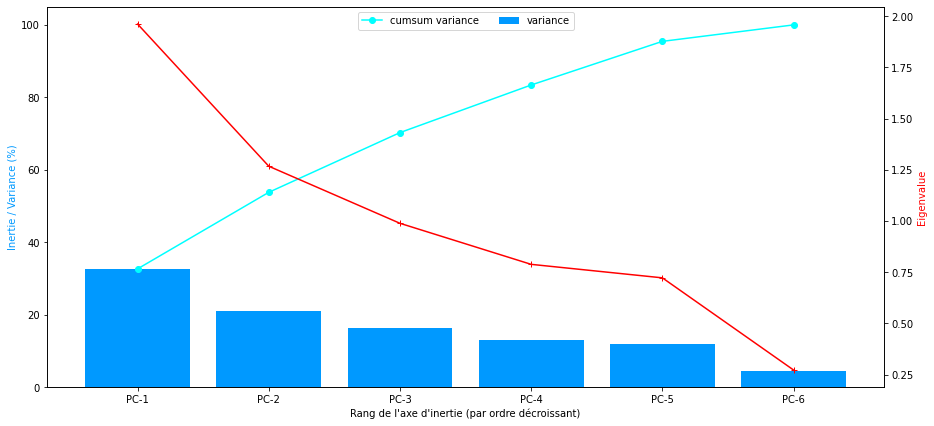

In [124]:
scree = pca.explained_variance_ratio_*100
eigenvalues = pca.explained_variance_
titles = [f"PC-{i+1}" for i in range(pca.n_components)]

fig = plt.figure(figsize=(15,7))
axis_1 = fig.add_subplot(111)
axis_1.bar(titles, scree, label='variance', color='#0099FF')
axis_1.plot(titles, scree.cumsum(),c="cyan",marker='o', label='cumsum variance')
axis_1.set_ylabel(r"Inertie / Variance (%)", color='#0099FF')
axis_1.set_xlabel(r"Rang de l'axe d'inertie (par ordre décroissant)")
axis_1.legend(loc=9, ncol=2)

axis_2 = axis_1.twinx()
axis_2.plot(titles, eigenvalues,c="red",marker='+', label="eigenvalues")
axis_2.set_ylabel(r"Eigenvalue", color='#FF0000')
#axis_2.legend(loc=5)

plt.show()

In [125]:
egeinvalues = pd.DataFrame({"egeinvalue":pca.explained_variance_, "egeinvalue ratio":pca.explained_variance_ratio_}, index=[i+1 for i in range(pca.n_components)])
egeinvalues['cumsum_ratio'] = egeinvalues['egeinvalue ratio'].cumsum()
egeinvalues


,egeinvalue,egeinvalue ratio,cumsum_ratio
1,1.961,0.327,0.327
2,1.267,0.211,0.538
3,0.989,0.165,0.703
4,0.788,0.131,0.834
5,0.722,0.120,0.955
6,0.273,0.045,1.000


> Si l'on utilise la méthode du coude, il convient de choisir **2 composantes principales**.
>
> Si l'on cherche à retenir au moins 90% de la variance, on voit qu'il faut garder **5 composantes principales**. <br>*(Notons que les 2 premières composantes, possèdent 50% de l'inertie à elles seules)*
>
> Si l'on se fie au critère de Keiser, une composante principale doit représenter au moins (100/nombre_composants)% *(ici 100/6=16.66%)* pour présenter de l'intérêt. Dans le cas présent, ce sont les **3 premières composantes principales**.

> Nous allons donc travailler avec **5 composantes principales** (soit les 4 premiers plans factoriels).

#### Projectons le jeu de données dans le nouvel espace

In [126]:
X_projected = pca.transform(X_scaled)
X_projected_pd = pd.DataFrame(X_projected)
X_projected_pd.shape

(7685, 6)

### 5.3.2 Étudions la variabilité des individus (leurs ressemblances et différences)

In [127]:
data_tmp = data_clean.copy()

In [128]:
data_tmp.head()

,code,nova_group,nutriscore_grade,nutriscore_score,pnns_groups_2,product_name,FVN_estimate_100g,calcium_100g,carbohydrates_100g,cholesterol_100g,...,fiber_100g,iron_100g,proteins_100g,salt_100g,saturated-fat_100g,sodium_100g,sugars_100g,trans-fat_100g,vitamin-a_100g,vitamin-c_100g
1,00000000000003429145,None,None,NaN,None,L.casei,0.000,0.083,9.800,0.024,...,0.000,0.000,2.700,0.100,0.900,0.040,9.800,0.039,0.000,0.007
2,0000000000017,None,None,NaN,None,Vitória crackers,1.324,0.057,70.100,0.000,...,6.617,0.003,7.800,1.400,3.080,0.560,15.000,0.081,0.000,0.008
4,000000000003327986,None,None,NaN,None,Filetes de pollo empanado,3.367,0.212,22.017,0.040,...,2.056,0.001,15.300,1.100,1.000,0.440,8.753,0.048,0.000,0.006
5,000000000004622327,None,None,NaN,None,Hamburguesas de ternera 100%,0.430,0.441,2.600,0.163,...,0.000,0.000,15.700,2.100,6.100,0.840,1.000,0.104,0.000,0.007
6,00000000001,4,None,NaN,None,hyde icon,0.000,0.135,33.311,0.029,...,1.604,0.001,9.298,1.533,4.693,0.613,17.566,0.058,0.000,0.003


In [129]:
data_tmp.reset_index(inplace=True, drop=True)

In [130]:
data_tmp.head()

,code,nova_group,nutriscore_grade,nutriscore_score,pnns_groups_2,product_name,FVN_estimate_100g,calcium_100g,carbohydrates_100g,cholesterol_100g,...,fiber_100g,iron_100g,proteins_100g,salt_100g,saturated-fat_100g,sodium_100g,sugars_100g,trans-fat_100g,vitamin-a_100g,vitamin-c_100g
0,00000000000003429145,None,None,NaN,None,L.casei,0.000,0.083,9.800,0.024,...,0.000,0.000,2.700,0.100,0.900,0.040,9.800,0.039,0.000,0.007
1,0000000000017,None,None,NaN,None,Vitória crackers,1.324,0.057,70.100,0.000,...,6.617,0.003,7.800,1.400,3.080,0.560,15.000,0.081,0.000,0.008
2,000000000003327986,None,None,NaN,None,Filetes de pollo empanado,3.367,0.212,22.017,0.040,...,2.056,0.001,15.300,1.100,1.000,0.440,8.753,0.048,0.000,0.006
3,000000000004622327,None,None,NaN,None,Hamburguesas de ternera 100%,0.430,0.441,2.600,0.163,...,0.000,0.000,15.700,2.100,6.100,0.840,1.000,0.104,0.000,0.007
4,00000000001,4,None,NaN,None,hyde icon,0.000,0.135,33.311,0.029,...,1.604,0.001,9.298,1.533,4.693,0.613,17.566,0.058,0.000,0.003


#### Regardons les `nutriscore_grade` sous l'angle des divers plans factoriels trouvé par l'ACP

In [131]:
Sample_index = data_tmp[ data_tmp.nutriscore_grade.notnull() ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Nutrigrade'] = data_tmp.loc[Sample_index]['nutriscore_grade']

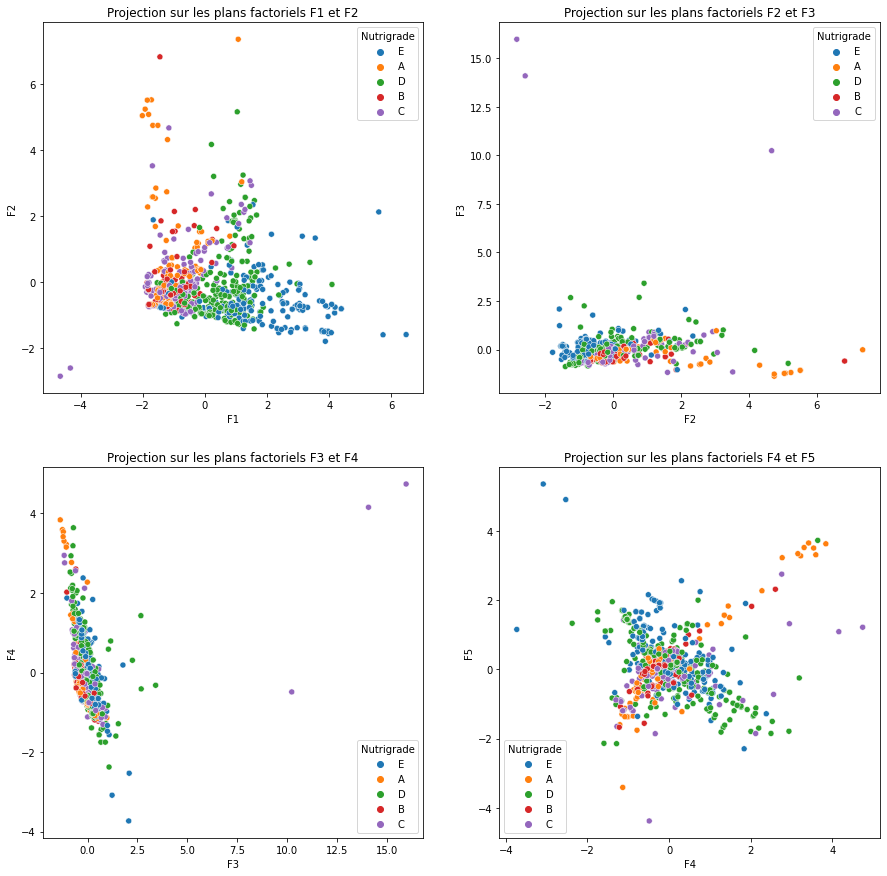

In [132]:
fig = plt.figure(figsize=(15,15))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(data=X_sample, x=i, y=i+1, hue='Nutrigrade')
    plt.title(f"Projection sur les plans factoriels F{i+1} et F{i+2}")
    ax.set_xlabel(f"F{i+1}")
    ax.set_ylabel(f"F{i+2}")

plt.show()

> Sur les deux premiers graphiques, on constate que les produits avec des `nutriscore_grade` similaires ont tendance à se regrouper en clusters. Ce n'est pas clairement visible pour tous les grades cependant.

#### Regardons les catégories `pnns_groups_2` sous l'angle des divers plans factoriels trouvé par l'ACP

In [133]:
num_cats = 10
top_categories = list(data_tmp['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

In [134]:
Sample_index = data_tmp[ data_tmp.pnns_groups_2.isin(top_categories) ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Categories'] = data_tmp.loc[Sample_index]['pnns_groups_2']

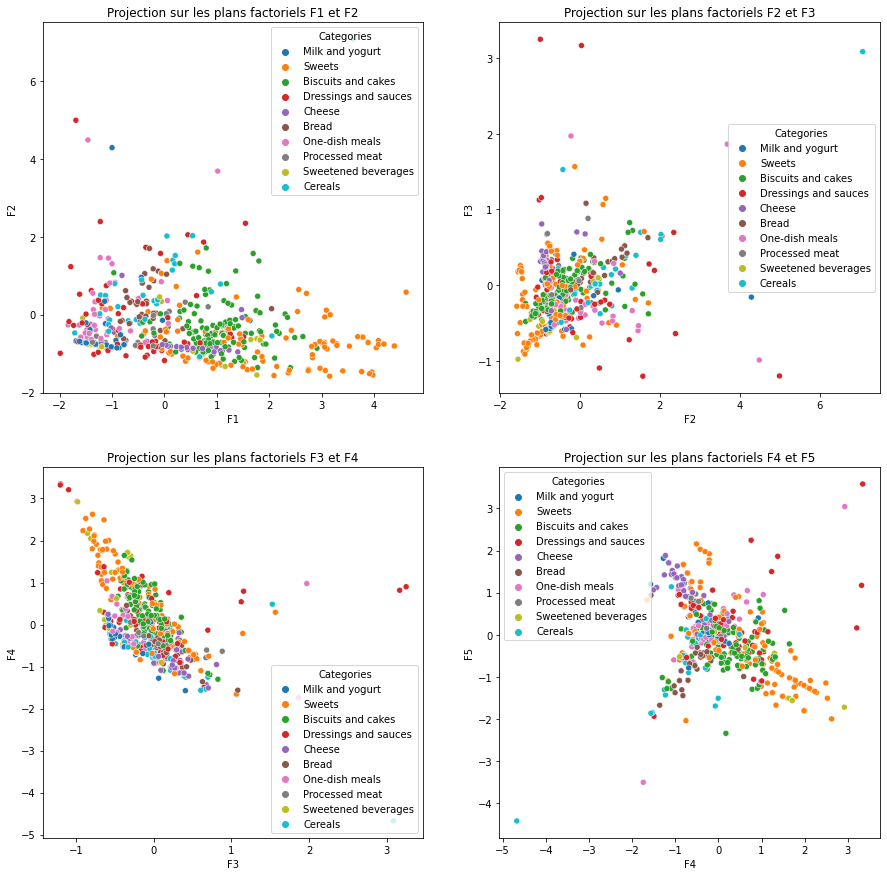

In [135]:
fig = plt.figure(figsize=(15,15))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    sns.scatterplot(data=X_sample, x=i, y=i+1, hue='Categories')
    plt.title(f"Projection sur les plans factoriels F{i+1} et F{i+2}")
    ax.set_xlabel(f"F{i+1}")
    ax.set_ylabel(f"F{i+2}")

plt.show()

> On constate que les produits avec des catégories `pnns_groups_2` similaires ont tendance à se regrouper en clusters.

### 5.3.3 Étudions les liaisons entre les variables

#### Affichons le tableau des corrélations de chaque composante principale avec les colonnes retenues

In [136]:
pcs = pca.components_

In [137]:
comp_all = pd.DataFrame(pcs, columns=X.columns, index=[f"F{x+1}" for x in range(len(pcs))])

<AxesSubplot:>

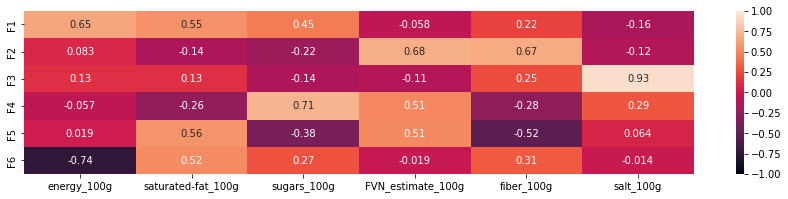

In [138]:
plt.figure(figsize=(15,3))
sns.heatmap(comp_all, vmin=-1, vmax=1, annot=True)

energy_100g = 0.67
saturated-fat_100g = 0.54
fiber_100g = 0.35
sugars_100g = 0.33

#### Affichons les moyennes par `nutriscore_grade` des valeurs sur chaque composante principales

In [139]:
Sample_index = data_tmp[ data_tmp.nutriscore_grade.notnull() ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Nutrigrade'] = data_tmp.loc[Sample_index]['nutriscore_grade']

In [140]:
pcs_grades = []
grades = ['A','B','C','D','E']
for grade in grades:
    pcs_grades.append(list(X_sample[ X_sample.Nutrigrade == grade].mean(numeric_only=True)))
 
pcs_grades_pd = pd.DataFrame(pcs_grades, index=grades, columns=[f"F{x+1}" for x in range(len(pcs))]).T

<AxesSubplot:>

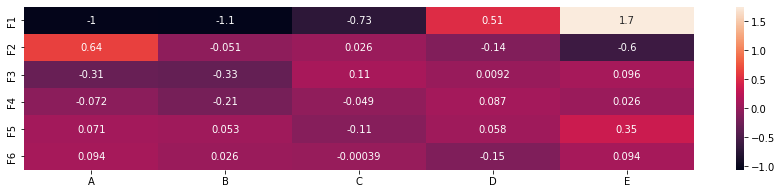

In [141]:
plt.figure(figsize=(15,3))
sns.heatmap(pcs_grades_pd, annot=True)

> - F1 fait une grosse différence entre les grades A,B,C d'une part et D,E d'autre part.
> - F2 fait à peu près la même chose mais en moins accentué et s'intéresse nettement moins à B.
> - F3 inverse la tendance et ne s'occupe plus que des extrêmes (A,E ou D dans une moins mesure).

#### Affichons les cercles de corrélations des divers plans factoriels

In [142]:
# Définissons une fonction permettant d'afficher les cercles de corrélations

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            #fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.show(block=False)

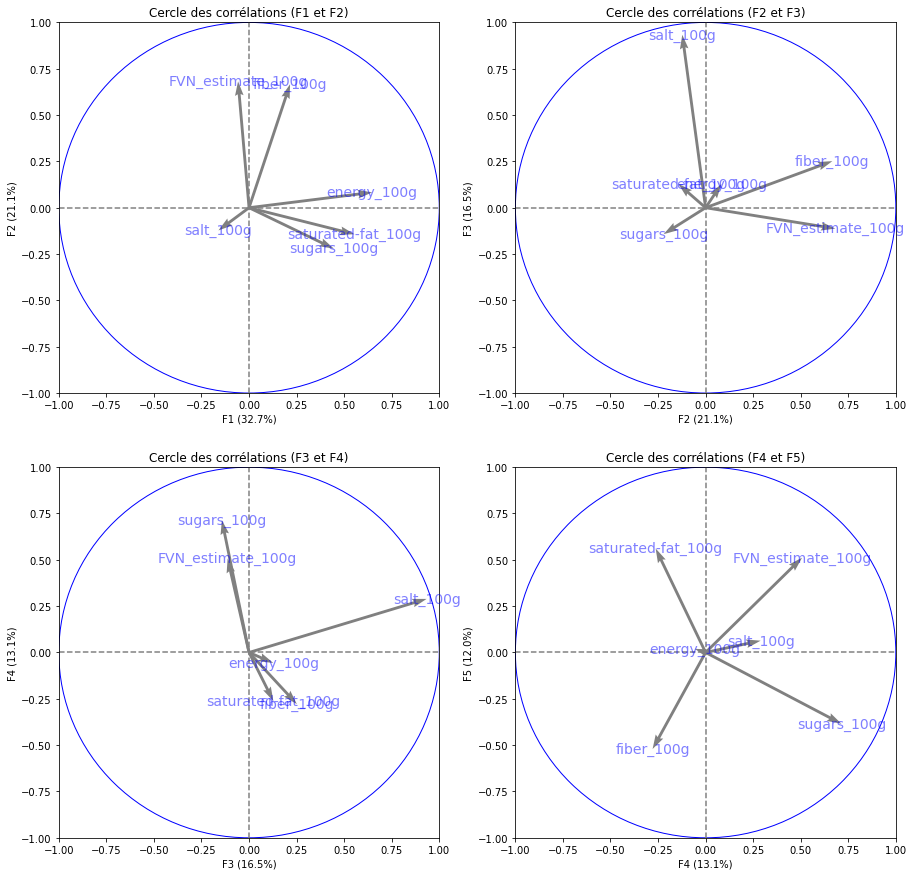

In [143]:
fig = plt.figure(figsize=(15,15))

num_p = 4
for i in range(num_p):
    ax = fig.add_subplot(2,2,i+1)
    display_circles(pcs, num_p+1, pca, [(i,i+1)], labels = X.columns, label_rotation=0)
    
plt.show()

L'angle entre deux vecteurs indique leur coefficient de correlation.<br>Plus la pointe d'un vecteur se rapproche du cercle et mieux le vecteur est représenté dans le plan étudié <br>(+1 ou -1 sont donc des représentations parfaites sur la composante).

> Sur **F1**, les colonnes suivantes ressortent:
> - `energy_100g` = 0.67
> - `saturat<ed-fat_100g` = 0.54
> - `fiber_100g` = 0.35
> - `sugars_100g` = 0.33
> 
>> Cette première composante principale pourrait être un axe basé sur **l'apport énergetique**.

> Sur **F2**, les colonnes suivantes ressortent:
> - `salt_100g` = 0.46
> - `saturated-fat_100g`
> - `fiber_100g` = -0.41
> - `FVN_estimate_100g` = -0.71
> 
>> Cette seconde composante principale pourrait être un axe basé qui oppose les produits plutôt **gras** aux produits plutôt **secs**.

> Sur **F3**, les colonnes suivantes ressortent:
> - `salt_100g` = 0.58
> - `fiber_100g` = 0.57
> - `sugars_100g` = -0.55
> 
>> Cette troisième composante principale pourrait être un axe qui oppose les produits **salés** aux produits **sucrés**.

## 5.4 Test statistique<a class="anchor" id="anova"></a>

Nous allons à présent vérifier statistiquement si les constatations faites précèdement concernant le rapport entre les differents `nutriscore_grade` et les indicateurs nutrionnels sélectionnés `energy_100g`, `saturated-fat_100g`, `sugars_100g`, `FVN_estimate_100g`, `fiber_100g`, `salt_100g`, sont **significatifs ou non**.

Commençons par établir les hypothèses que nous allons utiliser pour chaque indicateur nutritionnel conservé:
- **Hypothèse nulle $H_0$:** tous les grades ont les mêmes valeurs pour un indicateur nutrionnel donné; on ne peut pas différentier les grades.
- **Hypothèse alternative $H_1$:** au moins deux grades n'ont pas les mêmes valeurs pour un indicateur nutritionnel donné; on peut les différencier.

### 5.4.1 ANOVA *(ANalysis Of VAriance)*

Ce test permet comparer la différence entre deux ou plusieurs groupes/catégories de variables numériques. Donc de comparer une variable qualitatives comme le `nutriscore_grade` avec des variables quantitatives comme les indicateurs nutritionnels.

Pour être utilisable, l'ANOVA nécessite de respecter plusieurs hypothèses fondamentales:
- **Normalité de la distribution**
- **Indépendance des échantillons**

Nous avons vu lors des analyses univariées des variables numériques qu'aucune d'entre elles n'est de distribution normale. <br>Mais pour être certain, vérifions le à nouveau avec des diagrammes quantile-quantile *(QQplot)* qui ont le mérite d'être très parlant.

#### Diagrammes Quantile-Quantile

Le QQplot de comparaison d'une distribution observée avec une loi gaussienne réduite permet une validation subjective de la normalité :
- si les points sont alignés sur la première bissectrice c'est que la distribution suit probablement une loi de distribution gaussienne normalisée.
- si les points sont alignés sur une autre droite d'équation $x_i = a x_i^∗ + b$, c'est que la distribution suit une loi normale d'espérance b et d'écart type a. 

In [144]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm #, uniform

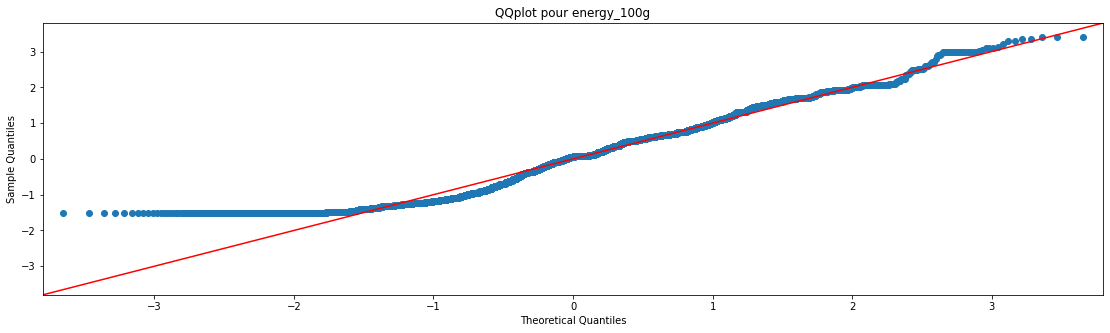

<function __main__.select_qqplot1(col)>

In [152]:
from scipy import stats

data_qqplot1 = data_clean.copy()

def select_qqplot1(col):
    fig = plt.figure(figsize=(19,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f"QQplot pour {col}")
    qqplot(data_qqplot1[data_qqplot1[col].notnull()][col], norm, fit=True, line="45", ax=ax)

interact(select_qqplot1, col=var_nutri_pca)

> On constate donc qu'**aucune des variables numériques considérées n'a une distribution normale**.
>
> Il n'est donc pas raisonnable d'utiliser l'ANOVA pour tester la significativité de la variance entre les différents `nutriscore_grade`.
>
> Heureusement, il existe une alternative qui ne nécessite pas d'avoir une distribution normale; le **test de Kruskal-Wallis** qui au lieu de s'intéresser à la variance, se concentre sur les médianes.

### 5.4.2 Kruskal-Wallis
Cette méthode non paramétrique est utilisée pour tester si des échantillons trouvent leur origine dans la même distribution. <br>Elle s'intéresse aux médianes de k populations ( k ⩾ 3).

- **Hypothèse nulle *(H0)*:** les k échantillons sont confondus et proviennent d'un même échantillon d'une population. On ne peut pas les différencier.

- **Hypothèse alternative *(H1)*:** les k échantillons ne sont PAS confondus, il existe une relation entre eux. On peut donc les différencier.

Le test permet de comparer deux ou plusieurs échantillons indépendants de taille similaire ou non.

In [ ]:
from scipy import stats

In [ ]:
data_drop = data_clean[var_nutri_pca].copy()
#data_drop['nutriscore_score'] = data_clean['nutriscore_score']
data_drop['nutriscore_grade'] = data_clean['nutriscore_grade']
data_drop.shape

#### 1. Supprimons les lignes avec des valeurs nulles *(donc les lignes sans nutriscore_grade)*

In [ ]:
data_drop.dropna(inplace=True)
data_drop.shape

#### 2. Calculons la p-valeur et la statistique de test pour chaque indicateur nutritionnel sélectionné

In [ ]:
for col in var_nutri_pca:
    s, p = stats.kruskal(*[data_drop[data_drop.nutriscore_grade == x][col] for x in ['A','B','C','D','E']])
    if p < 0.05:
        result="H0 est rejetée"
    else:
        result="H0 est validée"
    print(f"{col.rjust(25)} >> statistique = {s:9.2f} | p-valeur = {p:.2f} | {result}")

Rappelons les hypothèses $H_0$ et $H_1$:

- **Hypothèse nulle $H_0$:** la médiane est égale dans tous les grades pour un indicateur nutrionnel donné; on ne peut pas les différentier.
- **Hypothèse alternative $H_1$:** au moins deux grades n'ont pas la même médiane pour un indicateur nutritionnel donné; on peut les différencier.

> On constate que pour chaque indicateur nutritionnel, la p-valeur du test de Kruskal-Wallis est **inférieure à un niveau de test ($\alpha$) de 0.05** *(5%)*, et donc l'**hypothèse nulle $H_0$ est rejetée** à chaque fois.
>
> Les tests statistiques démontrent donc qu'il y a moins deux colonnes/grades dont les medianes des valeurs sont suffisament différentes pour être distinguées.

> L'ensemble du test confirme donc que ces differents indicateurs nutritionnels peuvent être des variables utiles pour un modèle prédictif dont le but est de prédire le `nutriscore_grade`.

# 6. Conclusions sur la faisabilité de l'application<a class="anchor" id="conclusion"></a>

1. Les analyses de données et le test statistiques indiquent qu'il est **raisonnable de s'appuyer sur les colonnes nutritionnelles sélectionnées pour prédire le `nutriscore_score` ou le `nutriscore_grade`**.


2. L'ACP montrent que **la dimensionnalité du jeu de donnée pourrait être légèrement réduite** tout en conservant un pouvoir prédictif sensiblement équivalent.


3. Sur la base de cette EDA, on peut prendre **deux directions pour le modèle prédictif** : prédire le nutriscore_grade directement ou prédire le nutriscore_score puis le convertir en nutriscore_grade.